# Building Damage

## Setting up

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)         #force_remount=True  # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
import os
rootPath = '/content/drive/My Drive/BuildingDamage_Model'
os.chdir(rootPath)

In [ ]:
import IPython.display as ipd
from scipy.io import wavfile

soundfile1 = 'Metal_Gong.wav'
soundfile2 = 'Warbling.wav'

In [ ]:
# Connect to google cloud 
! gcloud auth login

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext): 
              file_list.append(os.path.join(path, names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath + "/"

## Import Packages

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

## Read in Data

In [ ]:
%ls 'data'

All_Incidents_2013_2019_DINS_GDB/     damage_footprints/  McsftBuilding_CA/
All_Incidents_2013_2019_DINS_GDB.zip  FRAP_Perimeters/


### Building Footprints

In [ ]:
%ls 'data/McsftBuilding_CA'

Mcsft_file = lstFiles('data/McsftBuilding_CA', '.shp')
Mcsft_Building_CA = gpd.read_file(Mcsft_file[0])

In [ ]:
Mcsft_Building_CA.head()

FID                                           geometry
0    0  POLYGON ((-118.25464 33.78430, -118.25467 33.7...
1    1  POLYGON ((-118.25441 33.78426, -118.25441 33.7...
2    2  POLYGON ((-118.25302 33.78468, -118.25302 33.7...
3    3  POLYGON ((-118.25089 33.78505, -118.25081 33.7...
4    4  POLYGON ((-118.24961 33.78518, -118.24989 33.7...

### FRAP Fire Perimeters

In [ ]:
fire_perimeters = gpd.read_file('data/FRAP_Perimeters/FRAP_2012_2019.shp')

In [ ]:
fire_perimeters

### Structural Damage Data

In [ ]:
damage_file = lstFiles('data/All_Incidents_2013_2019_DINS_GDB', 'gdb')

In [ ]:
damage_gdb = gpd.read_file('data/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB/All_Incidents_2013_2019_DINS_GDB.gdb')

In [ ]:
damage_gdb['Year'] = pd.DatetimeIndex(damage_gdb['INCIDENTSTARTDATE']).year

In [ ]:
damage_gdb['Year'].min()

2013

### Basic Stats

pie charts: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

In [ ]:
print('Damage Classes: ', damage_gdb.DAMAGE.unique().tolist())
print('Fire Incidences: ', len(damage_gdb.INCIDENTNAME.unique().tolist()), damage_gdb.INCIDENTNAME.unique().tolist())
print('Structure Classes: ', len(damage_gdb.STRUCTURECATEGORY.unique()), damage_gdb.STRUCTURECATEGORY.unique().tolist())
print('STRUCTURETYPE: ', len(damage_gdb.STRUCTURETYPE.unique()), damage_gdb.STRUCTURETYPE.unique().tolist())
print('Fire Date: ', len(damage_gdb.INCIDENTSTARTDATE.unique().tolist()), damage_gdb.INCIDENTSTARTDATE.unique().tolist())
print('HAZARDTYPE: ', damage_gdb.HAZARDTYPE.unique().tolist())

Damage Classes:  ['Destroyed (>50%)', 'Affected (1-9%)', 'Major (26-50%)', 'Minor (10-25%)', 'No Damage', 'Inaccessible']
Fire Incidences:  110 ['Camp', 'Woolsey', 'Hill', 'Stoll', 'Pawnee', 'Ranch', 'River', 'Klamathon', 'Cranston', 'Carr', 'Holy', 'Grant', 'Frazier', 'Creek', 'Horse', 'Hyatt', 'Waverly', 'Ruby', 'County', 'West', 'Ridge', 'Irish', 'Nicolaus', 'Colusa', 'Vista', 'Carder', 'Spring', 'Marsh', 'Steele', 'Omega', 'Wagner', 'Delta', 'Meyers', 'Richmond', 'Holiday', 'Silver', 'Calgary', 'Ponderosa', 'Estate', 'Atlas', 'Nuns', 'Tubbs', 'Thomas', 'Pocket', 'Skirball', 'Bear', 'Cocos', 'Valley', 'Butte', 'Cascade', 'Clayton', 'Chimney', 'Sulphur', 'Black', 'Boles', 'Erskine', 'Soberanes', 'Tassajara', 'Round', 'Rocky', 'Stone', 'Alamo', 'Laverne', 'Whittier', 'Owens_River', 'Loma', 'Grade', 'Foothill', 'Thirty_Seven', 'Lilac', 'Mission', 'Peak', 'Detwiler', 'Redwood', 'Wall', 'Canyon_2', 'Cherokee', 'Laporte', 'McCourtney', 'Lobo', 'Spenceville', 'Pleasant', 'Helena', 'Goose',

In [ ]:
# drop inaccessible 
damage_gdb = damage_gdb[damage_gdb['DAMAGE'] != 'Inaccessible']

In [ ]:
groupedbyDamage = damage_gdb.groupby(['DAMAGE']).count().reset_index()
groupedbyDamage = groupedbyDamage[['DAMAGE', 'INCIDENTNUM']]
groupedbyDamage = groupedbyDamage.sort_values(by='INCIDENTNUM', ascending=True)
groupedbyDamage

DAMAGE  INCIDENTNUM
2    Major (26-50%)          351
3    Minor (10-25%)          662
0   Affected (1-9%)         2103
4         No Damage         6163
1  Destroyed (>50%)        38696

In [ ]:
groupedbyFire = damage_gdb.groupby(['INCIDENTNAME']).count().reset_index()
groupedbyFire = groupedbyFire[['INCIDENTNAME', 'INCIDENTNUM']]
groupedbyFire = groupedbyFire.sort_values(by='INCIDENTNUM', ascending=False)
bottom_count = groupedbyFire['INCIDENTNAME'][10:].tolist()
top10_count = groupedbyFire['INCIDENTNAME'][:10].tolist()
groupedbyFire.loc[groupedbyFire['INCIDENTNAME'].isin(bottom_count), 'INCIDENTNAME'] = 'Other'
groupedbyFire = groupedbyFire.groupby(['INCIDENTNAME'])['INCIDENTNUM'].sum().reset_index()
groupedbyFire = groupedbyFire.sort_values(by=['INCIDENTNUM'], ascending=True)
fireOrder = groupedbyFire['INCIDENTNAME'].unique().tolist()

In [ ]:
damageOrder = ['Major (26-50%)', 
              'Minor (10-25%)',
              'Affected (1-9%)', 
              'No Damage', 
              'Inaccessible',
              'Destroyed (>50%)']

In [ ]:
color_dict = {'Destroyed (>50%)': '#ff847c', 
              'Affected (1-9%)':'#ddf3f5', 
              'Major (26-50%)':'#ffbcbc', 
              'Minor (10-25%)':'#a6dcef', 
              'No Damage':'#e1ffc2', 
              'Inaccessible':'#ebecf1'}

In [ ]:
groupedbyFireDamage = damage_gdb.groupby(['INCIDENTNAME', 'DAMAGE', 'Year']).count().reset_index()
groupedbyFireDamage = groupedbyFireDamage[['INCIDENTNAME', 'DAMAGE', 'INCIDENTNUM',  'Year']]
groupedbyFireDamage.loc[groupedbyFireDamage['INCIDENTNAME'].isin(bottom_count), 'INCIDENTNAME'] = 'Other'
groupedbyFireDamage = groupedbyFireDamage.groupby(['INCIDENTNAME', 'DAMAGE',  'Year'])['INCIDENTNUM'].sum().reset_index()
groupedbyFireDamage = groupedbyFireDamage.sort_values(by=['DAMAGE'], ascending=True)
groupedbyFireDamage['fire_cst'] = pd.Categorical(
    groupedbyFireDamage['INCIDENTNAME'], 
    categories=fireOrder, 
    ordered=True
)

groupedbyFireDamage['damage_cst'] = pd.Categorical(
    groupedbyFireDamage['DAMAGE'], 
    categories=damageOrder, 
    ordered=True
)

groupedbyFireDamage = groupedbyFireDamage.sort_values(by=['fire_cst', 'damage_cst'])
groupedbyFireDamage['damage_color'] = groupedbyFireDamage['DAMAGE'].replace(color_dict, inplace=False)
groupedbyFireDamage.head()

INCIDENTNAME            DAMAGE  Year  ...  fire_cst        damage_cst damage_color
7         Butte    Major (26-50%)  2015  ...     Butte    Major (26-50%)      #ed973b
8         Butte    Minor (10-25%)  2015  ...     Butte    Minor (10-25%)      #ded389
5         Butte   Affected (1-9%)  2015  ...     Butte   Affected (1-9%)      #ded389
6         Butte  Destroyed (>50%)  2015  ...     Butte  Destroyed (>50%)      #6d0917
59       Thomas    Major (26-50%)  2017  ...    Thomas    Major (26-50%)      #ed973b

[5 rows x 7 columns]

In [ ]:
damage_colors = groupedbyFireDamage['damage_color'].tolist()
damage_labels = groupedbyFireDamage['DAMAGE'].tolist()

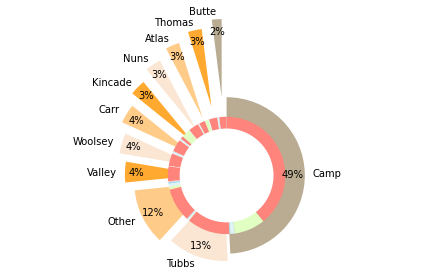

In [ ]:
import matplotlib.pyplot as plt

fire_count = groupedbyFire['INCIDENTNUM']
explode = (1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)

#add colors
fire_colors = ['#b9ac92','#ffa931','#fecb89','#fbe6d4',
          '#ffa931','#fecb89','#fbe6d4',
          '#ffa931','#fecb89','#fbe6d4']

fire_labels = groupedbyFire['INCIDENTNAME']

damage_count = groupedbyFireDamage['INCIDENTNUM']
damage_labels = groupedbyFireDamage['DAMAGE']

fig1, ax1 = plt.subplots()

ax1.pie(fire_count,
        explode=explode, 
        labels=fire_labels,
        startangle=90,
        colors = fire_colors,
        autopct='%1.0f%%', 
        pctdistance=0.85)


ax1.pie(damage_count,
        #explode=explode, 
        #labels=damage_labels,
        startangle=90,
        colors = damage_colors,
        #autopct='%1.0f%%',
        radius=0.75, 
        pctdistance=0.85)

#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('figures/damage_byFireDamage.jpeg', dpi=400)
plt.show()

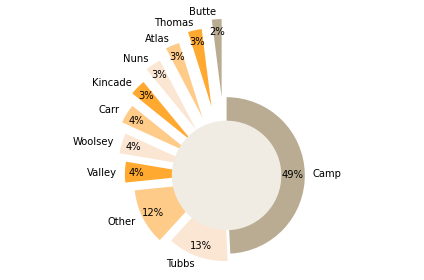

In [ ]:
import matplotlib.pyplot as plt
groupedbyFire = groupedbyFire.sort_values(by=['INCIDENTNUM'], ascending=True)
fire_count = groupedbyFire['INCIDENTNUM']
explode = (1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)

#add colors
fire_colors = ['#b9ac92','#ffa931','#fecb89','#fbe6d4',
          '#ffa931','#fecb89','#fbe6d4',
          '#ffa931','#fecb89','#fbe6d4']

fire_labels = groupedbyFire['INCIDENTNAME']

damage_count = groupedbyFireDamage['INCIDENTNUM']
damage_labels = groupedbyFireDamage['DAMAGE']

fig1, ax1 = plt.subplots()

ax1.pie(fire_count,
        explode=explode, 
        labels=fire_labels,
        startangle=90,
        colors = fire_colors,
        autopct='%1.0f%%', 
        pctdistance=0.85)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='#f0ece3')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('figures/damage_byFire.jpeg', dpi=400)
plt.show()

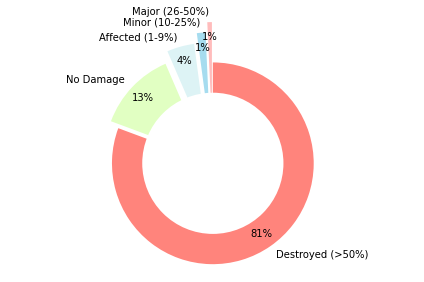

In [ ]:
explode = (0.4, 0.3, 0.2, 0.1, 0)

#add colors
groupedbyDamage['damage_color'] = groupedbyDamage['DAMAGE'].replace(color_dict, inplace=False)
damage2_colors = groupedbyDamage['damage_color'].tolist()

fig1, ax1 = plt.subplots()

damage_type_count = groupedbyDamage['INCIDENTNUM']

damage_type_labels = groupedbyDamage['DAMAGE']

ax1.pie(damage_type_count,
        explode = explode, 
        colors = damage2_colors,
        labels=damage_type_labels,
        autopct='%1.0f%%',
        startangle=90,
        pctdistance=0.85)
ax1.axis('equal')  

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.savefig('figures/damage_bytype.jpeg', dpi=400)
plt.show()

In [ ]:
groupedbyDamage

DAMAGE  INCIDENTNUM
2    Major (26-50%)          351
3    Minor (10-25%)          662
0   Affected (1-9%)         2103
4         No Damage         6163
1  Destroyed (>50%)        38696

In [ ]:
groupedbyFireDamage['Year'] = groupedbyFireDamage['Year'].astype('str')

In [ ]:
groupedbyFireDamage = damage_gdb.groupby(['DAMAGE', 'Year']).count().reset_index()
groupedbyFireDamage = groupedbyFireDamage[['DAMAGE', 'INCIDENTNUM',  'Year']]
groupedbyFireDamage = groupedbyFireDamage.groupby(['DAMAGE',  'Year'])['INCIDENTNUM'].sum().reset_index()
groupedbyFireDamage = groupedbyFireDamage.sort_values(by=['DAMAGE'], ascending=True)
# groupedbyFireDamage['fire_cst'] = pd.Categorical(
#     groupedbyFireDamage['INCIDENTNAME'], 
#     categories=fireOrder, 
#     ordered=True
# )

groupedbyFireDamage['damage_cst'] = pd.Categorical(
    groupedbyFireDamage['DAMAGE'], 
    categories=damageOrder, 
    ordered=True
)

groupedbyFireDamage = groupedbyFireDamage.sort_values(by=['damage_cst'])
groupedbyFireDamage['damage_color'] = groupedbyFireDamage['DAMAGE'].replace(color_dict, inplace=False)
groupedbyFireDamage = groupedbyFireDamage[groupedbyFireDamage['DAMAGE'] != 'No Damage']

In [ ]:
groupedbyFireDamage

In [ ]:
groupedbyFireDamage_piv = groupedbyFireDamage.pivot(index='Year', columns='DAMAGE', values='INCIDENTNUM').fillna(0)

In [ ]:
groupedbyFireDamage_piv = groupedbyFireDamage_piv[['Destroyed (>50%)', 'Major (26-50%)', 'Minor (10-25%)', 'Affected (1-9%)']]

In [ ]:
color_dict = {'Destroyed (>50%)': '#ff847c', 
              'Affected (1-9%)':'#ddf3f5', 
              'Major (26-50%)':'#ffbcbc', 
              'Minor (10-25%)':'#a6dcef', 
              'No Damage':'#e1ffc2', 
              'Inaccessible':'#ebecf1'}

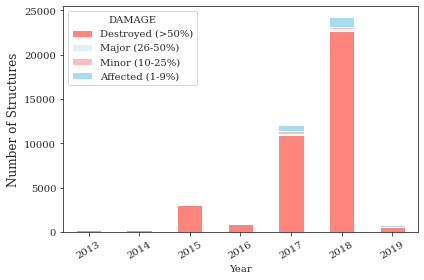

In [ ]:
import seaborn as sns

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})
plot_options = {'labelrotation':20}

groupedbyFireDamage_piv = groupedbyFireDamage_piv.sort_index()


ax1 = groupedbyFireDamage_piv.plot(kind='bar',stacked=True,legend=True, alpha=1,
                                   color=['#ff847c', '#ddf3f5', '#ffbcbc', '#a6dcef'])
ax1.set_ylabel('Number of Structures', fontsize=12)
plt.xticks(rotation=30, horizontalalignment="center")
plt.tight_layout()
plt.savefig('figures/annual_damagecount.jpeg', dpi=400)

In [ ]:
## Pivot table
grouped_damagedType = pd.pivot_table(groupedbyFireDamage, values='INCIDENTNUM', index=['INCIDENTNAME'],
                    columns=['DAMAGE']).reset_index()
grouped_damagedType.columns = ['INCIDENTNAME', 'Affected (1-9%)', 'Destroyed (>50%)', 
                               'Major (26-50%)',
                               'Minor (10-25%)', 'No Damage']
grouped_damagedType

grouped_damagedType[grouped_damagedType['INCIDENTNAME'].isin(top10_count)].reset_index() 

index INCIDENTNAME  ...  Minor (10-25%)  No Damage
0      0        Atlas  ...            21.0      469.0
1      1        Butte  ...             6.0        NaN
2      2         Camp  ...           101.0     4066.0
3      3         Carr  ...            39.0        NaN
4      4      Kincade  ...            14.0     1134.0
5      5         Nuns  ...            28.0       27.0
6      7       Thomas  ...            70.0       19.0
7      8        Tubbs  ...            75.0       74.0
8      9       Valley  ...            17.0        NaN
9     10      Woolsey  ...            66.0        NaN

[10 rows x 7 columns]

#### Interactive Map (Camp)

In [ ]:
color_dict = {'Destroyed (>50%)': '#6d0917', 
              'Affected (1-9%)':'#ded389', 
              'Major (26-50%)':'#ed973b', 
              'Minor (10-25%)':'#ded389', 
              'No Damage':'#606c38', 
              'Inaccessible':'#e5eefd'}


icon_dict = {'Single Residence': 'fa-caret-square-o-up', 
             'Other Minor Structure': 'fa-caret-square-o-up', 
             'Nonresidential Commercial': 'fa-building-o', 
             'Multiple Residence': 'fa-users', 
             'Mixed Commercial/Residential': 'fa-university', 
             'Infrastructure': 'fa-road', 
             'Agriculture': 'fa-leaf', 
             'Other': 'fa-fire'}

In [ ]:
import folium
from folium.plugins import MarkerCluster

f = folium.Figure(width=800, height=500)

m = folium.Map(location=[np.mean(damage_gdb['Latitide'][:10000]), np.mean(damage_gdb['Longitude'][:10000])], tiles='Cartodb Positron', zoom_start=14)

marker_cluster = MarkerCluster().add_to(m)

for i, row in damage_gdb[:10000].iterrows():
  lat_lon = (row['Latitide'], row['Longitude'])
  popup = 'Damage: {}<br>Fire Name: {}<br>Structure_Type: {}'.format(row['DAMAGE'], row['INCIDENTNAME'], row['STRUCTURETYPE'])
  color = color_dict[row['DAMAGE']]
  icon_marker = icon_dict[row['STRUCTURECATEGORY']]
  folium.Marker(lat_lon, 
                popup=popup,
                icon=folium.Icon(color = 'white', icon=icon_marker, icon_color=color, prefix='fa')
                ).add_to(marker_cluster)
 
marker_cluster.add_to(m)

f.add_child(m)

f

Output hidden; open in https://colab.research.google.com to view.

## Spatially join damage points with building geometry

In [ ]:
# read in bounds geometry
outpath = os.path.join('data', 'boundingbox_byfire')
bounds_gdf = gpd.read_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')
bounds_gdf.head()

NameError: ignored

In [ ]:
# Check spatial projections for all layers 
bounds_gdf.crs, Mcsft_Building_CA.crs, damage_gdb.crs

In [ ]:
damage_gdb = damage_gdb.to_crs(bounds_gdf.crs) 

In [ ]:
bounds_gdf = bounds_gdf[['Fire', 'Incident_dt', 'geometry']]
bounds_gdf

Fire Incident_dt                                           geometry
0      Alamo    7/6/2017  POLYGON ((-120.23380 34.93994, -120.22658 34.9...
1      Atlas  10/08/2017  POLYGON ((-122.33615 38.26864, -122.12848 38.2...
2       Bear  10/16/2017  POLYGON ((-122.07703 37.16648, -122.06340 37.1...
3      Boles   9/15/2014  POLYGON ((-122.38249 41.42218, -122.37521 41.4...
4      Butte   9/09/2015  POLYGON ((-120.70812 38.17402, -120.48622 38.1...
..       ...         ...                                                ...
71    Wagner    8/4/2018  POLYGON ((-120.10989 37.71196, -120.10844 37.7...
72      Wall    7/7/2017  POLYGON ((-121.44661 39.44453, -121.37033 39.4...
73      West    7/6/2018  POLYGON ((-116.75011 32.82518, -116.73707 32.8...
74  Whittier    7/8/2017  POLYGON ((-119.95499 34.55721, -119.94382 34.5...
75   Woolsey   11/8/2018  POLYGON ((-118.97147 34.00799, -118.66427 34.0...

[76 rows x 3 columns]

In [ ]:
# spatial join with study extent, add fire attribute 
building_filt = gpd.sjoin(Mcsft_Building_CA, bounds_gdf, how="inner", op='intersects')

In [ ]:
building_filt.to_file('data/filt_buildingfptn_CA.shp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [ ]:
building_filt = gpd.read_file('data/filt_buildingfptn_CA.shp')

## Get clipped poly layer for each fire event

Using the boundary extent taken from damage dataset, grab all building geometries available. This will allow area of interest to be restricted to places with damaged structures, but will also allow training dataset to have no-damage buildings for better representation. 

In [ ]:
def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 

fireyr_list = list(zip(building_filt['Fire'], building_filt['Incident_d']))
fireyr_list = removeDuplicates(fireyr_list)
len(fireyr_list)

fireyr_list = sorted(fireyr_list, key=lambda tup: tup[0])
fireyr_list

In [ ]:
# loop through and filter by fire and incident date 
# attribute join with damage attributes + date (point to polygon), keep all polygons! 
# add in 'No Damage' property for polygons with no attribute.... 
# save separate geojson files, make sure to have SAME extent as bounding box! 


for fire, dt in fireyr_list: 
  try: 
    filt_damage_gdb = damage_gdb[(damage_gdb['INCIDENTNAME'] == fire) & (damage_gdb['INCIDENTSTARTDATE'] == dt)]
    filt_building_poly = building_filt[(building_filt['Fire'] == fire) & (building_filt['Incident_dt'] == dt)]

    filt_building_poly = filt_building_poly[['Fire', 'Incident_dt', 'geometry']]

    new_building_damage = gpd.sjoin(filt_building_poly, filt_damage_gdb, how="left", op='intersects')


    values = {'DAMAGE': 'No Damage'}
    new_building_damage = new_building_damage.fillna(value=values). #.drop(columns=['index_righ', 'FID'])

    new_building_damage = new_building_damage[['Fire', 'Incident_dt', 'DAMAGE', 'geometry']]
    new_building_damage = new_building_damage.reset_index().drop(columns=['index'])
    
    event_bounds = bounds_gdf[bounds_gdf['Fire'] == fire]

    clipped_poly = gpd.clip(new_building_damage, event_bounds)

    firepath = createFolder(os.path.join('data','fires'), fire)
    polypath = createFolder(firepath, 'poly')

    clipped_poly.to_file(os.path.join(polypath, f'{fire}_{dt[-4:]}_buildingfptn.geojson'), driver='GeoJSON')
    clipped_poly.to_file(os.path.join(polypath, f'{fire}_{dt[-4:]}_buildingfptn.shp'))

    print('saved: ', fire, dt)
  except: 
    print('error: ', fire, dt)
    continue

In [ ]:
def getpolyattributes(fire, dt):
  filt_damage_gdb = damage_gdb[(damage_gdb['INCIDENTNAME'] == fire) & (damage_gdb['INCIDENTSTARTDATE'] == dt)]
  filt_building_poly = building_filt[(building_filt['Fire'] == fire) & (building_filt['Incident_d'] == dt)]

  filt_building_poly = filt_building_poly[['Fire', 'Incident_d', 'geometry']]

  new_building_damage = gpd.sjoin(filt_building_poly, filt_damage_gdb, how="left", op='intersects')


  values = {'DAMAGE': 'No Damage'}
  new_building_damage = new_building_damage.fillna(value=values)

  new_building_damage = new_building_damage[['Fire', 'Incident_d', 'DAMAGE', 'geometry']]
  new_building_damage = new_building_damage.reset_index().drop(columns=['index']) #.buffer(0)

  # event_bounds = bounds_gdf[bounds_gdf['Fire'] == fire]
  
  # clipped_poly = gpd.clip(new_building_damage, event_bounds)

  firepath = createFolder(os.path.join('data','fires'), fire)
  polypath = createFolder(firepath, 'poly')

  new_building_damage.to_file(os.path.join(polypath, f'{fire}_{dt[-4:]}_buildingfptn.geojson'), driver='GeoJSON')
  new_building_damage.to_file(os.path.join(polypath, f'{fire}_{dt[-4:]}_buildingfptn.shp'))

  return new_building_damage

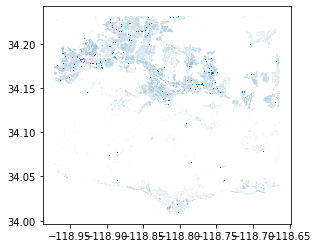

In [ ]:
bld_byfr = getpolyattributes('Woolsey', '11/8/2018') 
bld_byfr.plot()

In [ ]:
# add to cloud bucket 
! gsutil -m cp -R 'data/damage_footprints' gs://buildingassessment

## Visualize Housing Damage w/ Folium

In [ ]:
color_dict = {'Destroyed (>50%)': '#6d0917', 
              'Affected (1-9%)':'#ded389', 
              'Major (26-50%)':'#ed973b', 
              'Minor (10-25%)':'#ded389', 
              'No Damage':'#606c38', 
              'Inaccessible':'#e5eefd'}

building_damage['damage_color'] = building_damage['DAMAGE'].replace(color_dict, inplace=False)
filt_poly = building_damage[building_damage['INCIDENTNA'] == 'Camp']
filt_poly

In [ ]:
def createMapsByFire(fire_name, zoom_value):
  filt_poly = building_damage[building_damage['INCIDENTNA'] == fire_name]
  filt_points = damage_gdb[damage_gdb['INCIDENTNAME'] == fire_name]
  filt_perimeter = fire_perimeters[fire_perimeters['FIRE_NAME'] == fire_name.upper()]

  maploc = folium.Map(location=[np.mean(filt_points['Latitide']), np.mean(filt_points['Longitude'])],zoom_start=zoom_value,tiles="Stamen Toner")
  # add fire perimeters 
  folium.GeoJson(
      filt_perimeter,
      style_function=lambda feature: {
          'fillColor': '#ffdecf',
          'color' : '#900d0d',
          'weight' : 1,
          'fillOpacity' : 0.5,
          }
      ).add_to(maploc)

  # add in building polygons 
  # color by damage type 
  folium.GeoJson(
      filt_poly,
      style_function=lambda feature: {
          'fillColor': feature['properties']['damage_color'],
          'color' : feature['properties']['damage_color'],
          'weight' : 1,
          'fillOpacity' : 0.5,
          }
      ).add_to(maploc)

  marker_cluster = MarkerCluster().add_to(maploc)

  # add damage points into marker clusters 
  for i, row in filt_points.iterrows():
    lat_lon = (row['Latitide'], row['Longitude'])
    popup = 'Damage: {}<br>Fire Name: {}<br>Structure_Type: {}'.format(row['DAMAGE'], row['INCIDENTNAME'], row['STRUCTURETYPE'])
    color = color_dict[row['DAMAGE']]
    icon_marker = icon_dict[row['STRUCTURECATEGORY']]
    folium.Marker(lat_lon, 
                  popup=popup,
                  icon=folium.Icon(color = 'white', icon=icon_marker, icon_color=color, prefix='fa')
                  ).add_to(marker_cluster)
  
  marker_cluster.add_to(maploc)
  outpath = createFolder('figures', 'damageMaps')  
  maploc.save(f'{outpath}{fire_name}_fireDamage.html')
  return maploc

#### WOOLSEY FIRE

In [ ]:
! jupyter trust BuildingDamageDetection.ipynb
createMapsByFire('Woolsey', 12)

#### CARR FIRE

In [ ]:
createMapsByFire('Carr', 12)

#### ATLAS FIRE

In [ ]:
createMapsByFire('Atlas', 12)

#### CAMP FIRE

In [ ]:
from matplotlib.colors import ListedColormap
camp_poly = building_damage[building_damage['INCIDENTNA'] == 'Camp']

# Plot the data with a modified spatial extent
fig, ax = plt.subplots(figsize = (20,12))

xlim = ([camp_poly.total_bounds[0],  camp_poly.total_bounds[2]])
ylim = ([camp_poly.total_bounds[1],  camp_poly.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

colors = {'Destroyed (>50%)': 'red', 'Affected (1-9%)':'yellow', 'Major (26-50%)':'orange', 'Minor (10-25%)':'yellow', 'No Damage':'green', 'Inaccessible':'black'}
camp_poly.plot(ax = ax, legend=True, categorical=True, 
               color=camp_poly['DAMAGE'].apply(lambda x: colors[x]))

ax.set(title='Camp Fire Building Damages')
ax.set_axis_off()
plt.show()

## Grab extents of fire perimeters found in damage dataset

Extents are based on areas with damaged structures. Since these boundaries encompass an rectangular areas, this will allow areas with no-damaged structures to be included in the study region. 

In [ ]:
damage_gdb['Fire_Year'] = pd.to_datetime(damage_gdb['INCIDENTSTARTDATE'], format='%m/%d/%Y').dt.year

def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 
          
# Driver code 
fire_names = [x.upper() for x in damage_gdb['INCIDENTNAME']]
fire_list = list(zip(fire_names, damage_gdb['Fire_Year']))
fire_list = removeDuplicates(fire_list)
print(len(fire_list)) 

In [ ]:
fire_perimeters = gpd.read_file('data/FRAP_Perimeters/FRAP_2012_2019.shp')
fire_perimeters = fire_perimeters[fire_perimeters['FIRE_NAME'].isin([i[0] for i in fire_list])]


matched_fireyr_list = list(zip(fire_perimeters['FIRE_NAME'], fire_perimeters['YEAR_']))
matched_fireyr_list = removeDuplicates(matched_fireyr_list)
len(matched_fireyr_list)

83

In [ ]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

diff_list = Diff([i[0] for i in fire_list], [i[0] for i in matched_fireyr_list]) 

diff_list = [x.capitalize() for x in diff_list]
matched_fire_list = [x.capitalize() for x in [i[0] for i in matched_fireyr_list]]
len(damage_gdb[damage_gdb['INCIDENTNAME'].isin(diff_list)])
len(damage_gdb[damage_gdb['INCIDENTNAME'].isin(diff_list)]), len(damage_gdb[damage_gdb['INCIDENTNAME'].isin(matched_fire_list)]), len(damage_gdb)

(1318, 46555, 47995)

In [ ]:
len(diff_list)

43

In [ ]:
from shapely.geometry import Polygon

def getboundingbox(geom):
  '''
  Returns bounding box coordinated Polygon object. 
  Readable with geopandas
  '''
  minx = geom.bounds.iloc[:, 0].item()
  miny = geom.bounds.iloc[:, 1].item()
  maxx = geom.bounds.iloc[:, 2].item()
  maxy = geom.bounds.iloc[:, 3].item()
  return Polygon(((minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)))

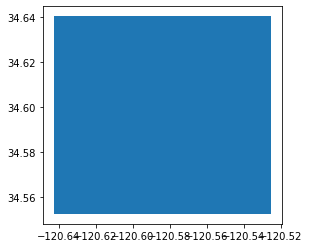

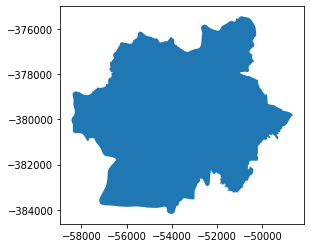

In [ ]:
len(fire_perimeters)

buff_geo = fire_perimeters.geometry.buffer(500)
buff_geo = buff_geo.to_crs('EPSG:4326') 
fire_coords = getboundingbox(buff_geo[1:2])
fire_bounds = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[fire_coords])   
fire_bounds.plot()
fire_perimeters[1:2].plot()

1. convert spatially joined building polygon layer (w/ structural damage attributes) to appropriate crs 
2. get all buildings with attributes i.e. disregard empty or na fields since these are likely no-damage polygons 
3. only include fires with more than 3 damaged structures
4. grab unique fire name instances groupbed by name and year 
5. using this tuple list go through and grab boundary coordinates 
6. return df with fire name, year, number of assessed buildings, Poly geometry

In [ ]:
building_damage = building_damage.to_crs('EPSG:4326') 

In [ ]:
building_damage['Fire_Year'] = pd.to_datetime(building_damage['INCIDENTSTARTDATE'], format='%m/%d/%Y').dt.year
sj_buildings = building_damage[building_damage['INCIDENTNAME'].notna()]
sj_byfire_count = sj_buildings.groupby(['INCIDENTNAME', 'Fire_Year'])['geometry'].count().reset_index()
fr_names = sj_byfire_count.loc[sj_byfire_count['geometry'] >= 3 , 'INCIDENTNAME']
fr_year = sj_byfire_count.loc[sj_byfire_count['geometry'] >= 3 , 'Fire_Year']

fr_yr_list = list(zip(fr_names, fr_year))

In [ ]:
from shapely.geometry import Polygon

def getfullextent(geodf):
  coords = geodf.geometry.bounds
  minx = coords['minx'].min()
  miny = coords['miny'].min()
  maxx = coords['maxx'].max()
  maxy = coords['maxy'].max()
  return Polygon(((minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)))


In [ ]:
# create df with fire name, bounds, year 

fire_name = [] 
year = []
incident_date = []
bounds = []
num_builds = [] 

for i, fire in enumerate(fr_yr_list):
  firenm = fire[0]
  fireyr = fire[1]
  filt_df = sj_buildings[(sj_buildings['INCIDENTNAME'] == firenm) & (sj_buildings['Fire_Year'] == fireyr)]
  area_coords = getfullextent(filt_df)
  fire_name.append(firenm)  
  year.append(fireyr)
  bounds.append(area_coords)
  num_builds.append(len(filt_df))
  incident_date.append(filt_df['INCIDENTSTARTDATE'][:1].item())


bounds_df = pd.DataFrame.from_dict({'Fire': fire_name, 
                                   'Year': year, 
                                    'Incident_dt':incident_date,
                                   'Building_cnt':num_builds, 
                                   'geometry': bounds})

In [ ]:
# convert df to geopandas 
bounds_gdf = gpd.GeoDataFrame(bounds_df, crs='EPSG:4326', geometry='geometry')
bounds_gdf

In [ ]:
outpath = createFolder('data', 'boundingbox_byfire')

bounds_gdf.to_file(os.path.join(outpath, 'boundingbox_byfire.shp'))
bounds_gdf.to_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


## Connect to GEE API

In [ ]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


### Export Files to Assets

In [ ]:
# export files hosted in cloud bucket as assets to GEE 
# needed to set up a bucket in google cloud: gs://esca_bucket
! earthengine upload table --asset_id=users/escaduto/BuildingAssessment/damage_buildingfptn_CA gs://buildingassessment/damage_footprints/damage_buildingfptn_CA.shp

## Get NAIP Imagery for each fire/year & Export to Drive

In [ ]:
def extract_coords(geom):
    '''
    takes one polygon from geopandas and converts it to the GEE geometry format
    input: geom from each row of the 'geometry' column in the gpd dataframe 
    output: coordinate list of the GEE geometry
    '''
    try:
        coords=geom.__geo_interface__['coordinates']
        geom_extr=[list(map(list,coord)) for coord in coords]
        return geom_extr
    except:
        pass

def get_bounds(gdf):
    '''
    takes a geo data frame get convert its bounding extent to a GEE format rectangle
    '''
    bounds=gdf.total_bounds
    geom_bound=[[ [bounds[0],bounds[1]], [bounds[2],bounds[1]], [bounds[2],bounds[3]], [bounds[0],bounds[3]]]]
    return geom_bound

In [ ]:
! pip install geopandas

In [ ]:
import geopandas as gpd
import pandas as pd

In [ ]:
# read in bounds geometry
outpath = os.path.join('data', 'boundingbox_byfire')
bounds_gdf = gpd.read_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')
bounds_gdf.tail()

Fire  ...                                           geometry
71    Wagner  ...  POLYGON ((-120.10989 37.71196, -120.10844 37.7...
72      Wall  ...  POLYGON ((-121.44661 39.44453, -121.37033 39.4...
73      West  ...  POLYGON ((-116.75011 32.82518, -116.73707 32.8...
74  Whittier  ...  POLYGON ((-119.95499 34.55721, -119.94382 34.5...
75   Woolsey  ...  POLYGON ((-118.97147 34.00799, -118.66427 34.0...

[5 rows x 5 columns]

In [ ]:
# lst_fires = ('Valley') # 'County', 'Thomas', 'Valley'
# bounds_gdf = bounds_gdf[bounds_gdf['Fire'] == (lst_fires)]
# bounds_gdf = bounds_gdf.reset_index().drop(columns = ['index'])
# bounds_gdf

Fire  ...                                           geometry
0  Valley  ...  POLYGON ((-122.76069 38.69981, -122.45706 38.6...

[1 rows x 5 columns]

### PostFire Imagery

In [ ]:
rootPath = '/content/drive/My Drive/BuildingDamage_Model'

def getPostFireNAIP(bounds_gdf_input):
  # convert incident dt to datetime to access month, day, year
  bounds_gdf_input['Incident_dt'] = pd.to_datetime(bounds_gdf_input['Incident_dt'], format='%m/%d/%Y')

  
  for i, eachInstance in bounds_gdf_input.iterrows():
    os.chdir(rootPath)
    firenm = eachInstance.Fire
    fireyr = eachInstance.Year
    firedt = eachInstance.Incident_dt
    startYr = str(fireyr)[:4]
    startMth = str(firedt.month)
    startDy = str(firedt.day)
    endYr = str(fireyr+3)[:4]
    new_gdf = gpd.GeoDataFrame(bounds_gdf_input[i:i+1], crs='EPSG:4326', geometry= 'geometry')
    bounds = get_bounds(new_gdf)
    Bound_Box = ee.Geometry.Polygon(bounds)
    print(bounds)
    print(f'{startYr}-{startMth}-{startDy}', f'{endYr}-12-31')
    postFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                    .filter(ee.Filter.date(f'{startYr}-{startMth}-{startDy}', f'{endYr}-12-31'))
                    .select(['R', 'G', 'B', 'N'])
                    .filterBounds(Bound_Box)
                    .mosaic());

    postFire = postFire.clip(Bound_Box)
    
    firepath = createFolder(os.path.join('data','fires'), firenm)
    polypath = createFolder(firepath, 'RGBN')
    
    os.chdir(firepath)
    
    exporttask = ee.batch.Export.image.toDrive(image=postFire, 
                                               description=f'{firenm}_{startYr}_postfire', 
                                               folder='RGBN', 
                                               region=Bound_Box, 
                                               scale=1,
                                               maxPixels = 10000000000)
    exporttask.start()
    
    print(firenm, startYr, endYr)
    

  return postFire

In [ ]:
# extract NAIP based on fire year and extent 
# save into drive 'RGBN' folder 
postFire = getPostFireNAIP(bounds_gdf)

[[[-122.760688, 38.699812], [-122.45706, 38.699812], [-122.45706, 38.883149], [-122.760688, 38.883149]]]
2015-9-12 2018-12-31
Valley 2015 2018


In [ ]:
# trueColorVis = {
#   min: 0.0,
#   max: 255.0,
# };

Map = emap.Map(center=[34.1181,-118.8178], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(postFire.select(['R', 'G', 'B']), '', 'Postfire')
Map.addLayerControl()
Map

### PreFire Imagery

In [ ]:
!cd '/content/drive/My Drive/BuildingDamage_Model/data'
!ls

os.getcwd()

RGBN


'/content/drive/My Drive/BuildingDamage_Model/data/prefire_data/Alamo'

In [ ]:
! earthengine task cancel all

In [ ]:
rootPath = '/content/drive/My Drive/BuildingDamage_Model/data'
from datetime import datetime, timedelta

def getPreFireNAIP(bounds_gdf_input):
  # convert incident dt to datetime to access month, day, year
  bounds_gdf_input['Incident_dt'] = pd.to_datetime(bounds_gdf_input['Incident_dt'], format='%m/%d/%Y')
  for i, eachInstance in bounds_gdf_input.iterrows():
    os.chdir(rootPath)
    firenm = eachInstance.Fire
    fireyr = eachInstance.Year
    firedt = eachInstance.Incident_dt - timedelta(days=5) # at least 5 days prior to fire event
    endYr = str(fireyr)[:4]
    endMth = str(firedt.month)
    endDy = str(firedt.day)
    startYr = str(fireyr - 3)[:4]
    new_gdf = gpd.GeoDataFrame(bounds_gdf_input[i:i+1], crs='EPSG:4326', geometry= 'geometry')
    bounds = get_bounds(new_gdf)
    Bound_Box = ee.Geometry.Polygon(bounds)
    print(bounds)
    print(f'{startYr}-01-01', f'{endYr}-{endMth}-{endDy}')
    preFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                    .filter(ee.Filter.date(f'{startYr}-01-01', f'{endYr}-{endMth}-{endDy}'))
                    .select(['R', 'G', 'B', 'N'])
                    .filterBounds(Bound_Box)
                    .mosaic());

    preFire = preFire.clip(Bound_Box)
    
    firepath = createFolder(os.path.join('prefire_data'), firenm)
    polypath = createFolder(firepath, 'RGBN')
    
    os.chdir(firepath)
    
    exporttask = ee.batch.Export.image.toDrive(image=preFire, 
                                               description=f'{firenm}_{endYr}_preFire', 
                                               folder='RGBN', 
                                               region=Bound_Box, 
                                               scale=1,
                                               maxPixels = 10000000000)
    exporttask.start()
    
    print(firenm, startYr, endYr, os.getcwd())
    

  return preFire

In [ ]:
bounds_gdf[-1:]

Fire  ...                                           geometry
75  Woolsey  ...  POLYGON ((-118.97147 34.00799, -118.66427 34.0...

[1 rows x 5 columns]

In [ ]:
# extract NAIP based on fire year and extent 
# save into drive 'RGBN' folder 
preFire = getPreFireNAIP(bounds_gdf)

[[[-118.971475, 34.007991], [-118.664271, 34.007991], [-118.664271, 34.230822], [-118.971475, 34.230822]]]
2015-01-01 2018-11-3
Woolsey 2015 2018 /content/drive/My Drive/BuildingDamage_Model/data/prefire_data/Woolsey


In [ ]:
# trueColorVis = {
#   min: 0.0,
#   max: 255.0,
# };

Map = emap.Map(center=[34.1181,-118.8178], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(preFire.select(['R', 'G', 'B']), '', 'preFire')
Map.addLayerControl()
Map

## Create CHIPS RGBN, Footprint

In [ ]:
!pip uninstall -y shapely;

Uninstalling Shapely-1.7.0:
  Successfully uninstalled Shapely-1.7.0


In [ ]:
!pip install git+git://github.com/toblerity/shapely.git

  Cloning git://github.com/toblerity/shapely.git to /tmp/pip-req-build-xobf5k5i
  Running command git clone -q git://github.com/toblerity/shapely.git /tmp/pip-req-build-xobf5k5i
  Created wheel for Shapely: filename=Shapely-1.8.dev0-py2.py3-none-any.whl size=92528 sha256=1964c5663ec4443233102f4900cabcd7a4668478c1a7047ccbce883033dafa6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfx2juzl/wheels/55/53/ce/4f22e2f80be4797602c76975a363ca8a7aaab92bfb28d832d6
Successfully built Shapely
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
#!pip install git+git://github.com/toblerity/shapely.git
!pip install solaris
!pip install rio-tiler

ipd.display(ipd.Audio(soundfile1, autoplay=True))

In [ ]:
import solaris as sol
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os

In [ ]:
import solaris as sol
from rasterio.plot import show
import os

rootPath = '/content/drive/My Drive/BuildingDamage_Model'
os.chdir(rootPath)


def readInRas(fire_nm, fire_yr, tif):
  ras_file = rasterio.open(tif) #f'data/fires/{fire_nm}/RGBN/{fire_nm}_{fire_yr}_postfire.tif'
  #show(ras_file)
  return ras_file 

def createChips(fire_nm, fire_yr, raster_tiler, tif, foldername):
  ras_file = readInRas(fire_nm, fire_yr, tif)
  while True:
    try:
      raster_bounds_crs = raster_tiler.tile(ras_file)
    except:
      print('Error, trying again!')
      continue
    break
  root_path = f'data/{foldername}/{fire_nm}'
  vect_tile_outpath = createFolder(root_path, 'label_chips')
  vector_tiler = sol.tile.vector_tile.VectorTiler(dest_dir= vect_tile_outpath,
                                                verbose=False)
  
  gdf = gpd.read_file(f'data/{foldername}/{fire_nm}/poly/{fire_nm}_{fire_yr}_buildingfptn.geojson')
  gdf['geometry'] = gdf['geometry'].buffer(0)
  
  vector_tiler.tile(gdf,
                  tile_bounds=raster_tiler.tile_bounds,
                  tile_bounds_crs=raster_bounds_crs)
  
def initiateTilers(fire_nm, fire_yr, foldername):
  print(fire_nm, fire_yr)
  root_path = f'data/{foldername}/{fire_nm}'
  rast_tile_outpath = createFolder(root_path, 'rast_chips')
  
  
  lst_tifs = lstFiles(os.path.join(root_path, 'RGBN'), '.tif')
  if len(lst_tifs) == 1: 
    raster_tiler = sol.tile.raster_tile.RasterTiler(dest_dir= rast_tile_outpath,  # the directory to save images to
                                                src_tile_size=(250, 250),
                                                verbose=False)
    createChips(fire_nm, fire_yr, raster_tiler, lst_tifs[0], foldername)
  elif len(lst_tifs) > 1: 
    for n, og_tifs in enumerate(lst_tifs): 
      tif = f'data/{foldername}/{fire_nm}/RGBN/{fire_nm}_{fire_yr}_postfire{str(n)}.tif'
      os.rename(og_tifs, tif)
      raster_tiler = sol.tile.raster_tile.RasterTiler(dest_dir= rast_tile_outpath,  # the directory to save images to
                                                src_tile_size=(250, 250),
                                                verbose=False)
      print(f'{str(n+1)} of {str(len(lst_tifs))} tif files')
      print(f'tif name {tif}')
      createChips(fire_nm, fire_yr, raster_tiler, tif, foldername)
  
  else: 
    print('no file found')  

### Add ID to Chips & Labels Name

In [ ]:
def renameFiles(tile_tifs, tile_poly, fire_nm, foldername):
  for m, poly in enumerate(list(zip(tile_tifs, tile_poly))):
    nm = poly[0].split('/')
    nm = nm[-1]
    nm = nm.split('_')
    addon = '_'.join(nm[:-3])
    coords = '_'.join(nm[-2:])[:-4]
    os.rename(poly[0], f'data/{foldername}/{fire_nm}/rast_chips/{addon}_{m}_{coords}.tif')
    os.rename(poly[1], f'data/{foldername}/{fire_nm}/label_chips/{addon}_{m}_{coords}.geojson')

### Execute Tiling for All Fire Events

In [ ]:
import pandas as pd
# get list of fire and year 
#bounds_gdf['Fire_Year'] = pd.to_datetime(bounds_gdf['Year'], format='%m/%d/%Y').dt.year

def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 
          
# Driver code 
fire_names = [x.capitalize() for x in bounds_gdf['Fire']]
fire_list = list(zip(fire_names, bounds_gdf['Year']))
fire_list = removeDuplicates(fire_list)

fire_list = sorted(fire_list, key=lambda tup: tup[0])
len(fire_list)

76

In [ ]:
from rasterio.plot import show
lst_samplefire = lstFiles('data/fires/Nuns/RGBN', 'tif')
RIO_Ras = rasterio.open(lst_samplefire[0])
show(RIO_Ras)

In [ ]:
lst_samplefire = lstFiles('data/fires/Nuns/poly', 'geojson')
nuns_poly = gpd.read_file(lst_samplefire[0])
nuns_poly.plot()

In [ ]:
# file_exists = glob.glob(f'data/prefire_data/*/RGBN/*.tif')
# for tif in file_exists: 
#   nm = tif.split('/')
#   nm = nm[-1]
#   nm = nm.split('_')
#   firenm = '_'.join(nm[:-2])
  
#   yr = [y for x, y in fire_list if x==firenm.capitalize()]
  
#   new_name = f'data/prefire_data/{firenm}/RGBN/{firenm}_{str(yr[0])[:4]}_{nm[-1]}'
#   os.rename(tif, new_name)
# print('complete')

complete


In [ ]:
# file_exists = glob.glob(f'data/postfire_data/*/poly/*.geojson')

In [ ]:
# from shutil import copyfile
# rootPath = r'data/prefire_data'

# for jsons in file_exists:
#   nm = jsons.split('/')
#   nm = nm[-1]
#   nm = nm.split('_')
#   firenm = '_'.join(nm[:-2])
#   print(os.path.join(rootPath, firenm))
#   createFolder(os.path.join(rootPath, firenm), 'poly')
#   dfire_listst = jsons.replace('postfire_data', 'prefire_data')
#   copyfile(jsons, dst)

In [ ]:
fire_list

In [ ]:
fire_list = [('Butte', 2015),
 ('Forty_Six_46th', 2019),('McCourtney', 2017),
 ('Ranch', 2018), ('Tubbs', 2017), 
 ('Vista', 2018), ('Wagner', 2018),
 ('Whittier', 2017), ('Wall', 2017),
 ('West', 2018), ('Woolsey', 2018)]

In [ ]:
fire_list[-1:]

#Woolsey', 2018.0

[('Woolsey', 2018.0)]

In [ ]:
%%capture

import glob 
import numpy
import IPython.display as ipd
import time 

for fire_nm, fire_yr in fire_list[-1:]:
  fire_yr = str(fire_yr)[:4]
  foldername = 'prefire_data'
  file_exists = glob.glob(f'data/{foldername}/{fire_nm}/RGBN/{fire_nm}_{fire_yr}*.tif')
  print(file_exists)
  try: 
    if os.path.isdir(f'data/{foldername}/{fire_nm}') == True and len(file_exists) > 0:
      initiateTilers(fire_nm, fire_yr, foldername)
      tile_tifs = lstFiles(f'data/{foldername}/{fire_nm}/rast_chips', '.tif')
      tile_poly = lstFiles(f'data/{foldername}/{fire_nm}/label_chips', '.geojson')
      # if len(tile_tifs) == len(tile_poly):
      #   renameFiles(tile_tifs, tile_poly, fire_nm, foldername)

      print('Processing completed for: ', fire_nm, fire_yr)
      ipd.display(ipd.Audio(soundfile1, autoplay=True))
      time.sleep(4)
  except: 
    print('ERROR FOR: ', fire_nm, fire_yr)
    continue



ipd.display(ipd.Audio(soundfile2, autoplay=True))

In [ ]:
# Warning: To Delete Existing Files!
# import shutil

# shutil.rmtree(r'data/prefire_data/Woolsey/rast_chips')

In [ ]:
# !ls data/prefire_data/Ranch

In [ ]:
!cd data/prefire_data/Ranch

In [ ]:
!ls data/prefire_data/Woolsey/label_chips

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot access 'data/prefire_data/Ranch/label_chips': Transport endpoint is not connected


In [ ]:
tile_tifs = lstFiles(f'data/prefire_data/Woolsey/rast_chips', '.tif')
tile_poly = lstFiles(f'data/prefire_data/Woolsey/label_chips', '.geojson')
#renameFiles(tile_tifs, tile_poly, 'Ranch', 'prefire_data')
len(tile_tifs),len(tile_poly)

(13200, 19)

In [ ]:
for fl in tile_tifs: 
  os.remove(fl)

In [ ]:
import glob 
# Carr  15162 15048 (replace dupes) 
ras_exists = glob.glob(f'data/prefire_data/Woolsey/rast_chips/*.tif')
len(tile_tifs) - len(ras_exists) , len(tile_poly), len(tile_tifs)

(0, 0, 5703)

In [ ]:
ras_exists

In [ ]:
glob.glob(f'data/prefire_data/Ranch/label_chips/*-122.77_39.371.geojson')

glob.glob(f'data/prefire_data/Ranch/rast_chips/Ranch_2018_3952_-122.77_39.371.tif')

['data/prefire_data/Ranch/rast_chips/Ranch_2018_3952_-122.77_39.371.tif']

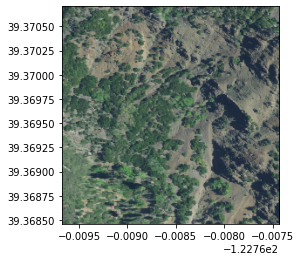

In [ ]:
from rasterio.plot import show
RIO_Ras = rasterio.open('data/prefire_data/Ranch/rast_chips/Ranch_2018_3952_-122.77_39.371.tif')

show(RIO_Ras)

In [ ]:
import os 

def replaceDupes(fire_nm, fire_yr, postfire_ID):
  tile_tifs = lstFiles(f'data/prefire_data/{fire_nm}/rast_chips', '.tif')
  tile_poly = lstFiles(f'data/prefire_data/{fire_nm}/label_chips', '.geojson')
  ras_exists = glob.glob(f'data/prefire_data/{fire_nm}/rast_chips/*postfire*.tif')
  print(fire_nm, len(tile_poly) + len(ras_exists), len(tile_tifs))
  if (len(tile_poly) + len(ras_exists)) == len(tile_tifs):
    for ras in ras_exists: 
      nm = ras.split('/')
      nm = nm[-1]
      nm = nm.split('_')
      coords = '_'.join(nm[-2:])[:-4]
      print(coords)
      json_file = glob.glob(f'data/prefire_data/{fire_nm}/label_chips/{fire_nm}_{fire_yr}_*_{coords}.geojson')
      jsn = json_file[0].split('/')
      jsn = jsn[-1] 
      jsn = jsn.split('_')
      ID = jsn[2]
      x = ras.replace(postfire_ID, ID)
      print(ras, x)
      os.replace(ras, x)


In [ ]:
replaceDupes('Thomas', '2017', 'postfire0')

In [ ]:
import os
import shutil

def moveFiles(fire_nm, file_exists, folder):
  for file_pth in file_exists:
    nm = file_pth.split('/')
    nm = nm[-1]
    fl_name = nm
    shutil.move(file_pth, f'data/fires/{fire_nm}/{folder}/{fl_name}')

In [ ]:
# moveFiles('Thomas', file_exists, 'label_chips')
ipd.display(ipd.Audio(soundfile1, autoplay=True))

In [ ]:
lstFiles(f'data/fires/Carr/rast_chips', '.tif')[15046:], lstFiles(f'data/fires/Carr/label_chips', '.geojson')[15046:]

In [ ]:
from rasterio.plot import show
RIO_Ras = rasterio.open('data/fires/Carr/rast_chips/Carr_2018_14934_-122.409_40.51.tif')

show(RIO_Ras)

## Create Training/Test Dataset

### Filter to only include tiles with building footprints and save into csv

In [ ]:
sample_json = lstFiles('data/fires/Alamo/label_chips', '.geojson')
gdf = gpd.read_file(sample_json[29])

In [ ]:
len(gdf['geometry']), len(gdf[gdf['DAMAGE'] != 'No Damage']) 


(2, 0)

In [ ]:
! pip install geopandas

In [ ]:
import geopandas as gpd
# read in bounds geometry
outpath = os.path.join('data', 'boundingbox_byfire')
bounds_gdf = gpd.read_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')
bounds_gdf.head()

Fire  ...                                           geometry
0  Alamo  ...  POLYGON ((-120.23380 34.93994, -120.22658 34.9...
1  Atlas  ...  POLYGON ((-122.33615 38.26864, -122.12848 38.2...
2   Bear  ...  POLYGON ((-122.07703 37.16648, -122.06340 37.1...
3  Boles  ...  POLYGON ((-122.38249 41.42218, -122.37521 41.4...
4  Butte  ...  POLYGON ((-120.70812 38.17402, -120.48622 38.1...

[5 rows x 5 columns]

In [ ]:
import pandas as pd
# get list of fire and year 
#bounds_gdf['Fire_Year'] = pd.to_datetime(bounds_gdf['Year'], format='%m/%d/%Y').dt.year

def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 
          
# Driver code 
fire_names = [x for x in bounds_gdf['Fire']]
fire_list = list(zip(fire_names, bounds_gdf['Year']))
fire_list = removeDuplicates(fire_list)
fire_list.append(('Valley2', '2015.0'))
fire_list = sorted(fire_list, key=lambda tup: tup[0])
len(fire_list)

77

In [ ]:
def getLoadedFiles(fire_nm, fire_yr, foldername):
  '''
  check to see if the geojson files contain geometry (at least one)
  get and save file name into list 
  return list
  '''
  geo_count = [] 
  damage_count = [] 
  fire_name = [] 
  pathnm = [] 
  json_list = lstFiles(f'data/{foldername}/{fire_nm}/label_chips', '.geojson')
  for json in json_list: 
    gdf = gpd.read_file(json)
    if gdf['geometry'].empty == False: # i.e. len(gdf['geometry']) > 0 
      geo_count.append(len(gdf['geometry']))
      damage_count.append(len(gdf[gdf['DAMAGE'] != 'No Damage']))
      fire_name.append(fire_nm)
      pathnm.append(json) 

  df = pd.DataFrame({'Fire': fire_name,  'damage_count': damage_count, 
                     'geo_count': geo_count,'Path': pathnm}) 
  outpath = createFolder(f'data/{foldername}/{fire_nm}', 'csv_files')
  df.to_csv(os.path.join(outpath, f'{fire_nm}_{fire_yr}_loadedGeoTiles.csv'))
  return df 

In [ ]:
import glob
foldername = 'prefire_data'
csv_files = glob.glob(f'data/{foldername}/*/csv_files/*.csv')


In [ ]:
csv_files

In [ ]:
import pandas as pd
for csv in csv_files: 
  nm = csv.split('/')
  nm = nm[-1]
  fl_name = nm
  nmm = fl_name.split('_')
  firenm = nmm[0]
  year = nmm[1]
  df = pd.read_csv(csv)
  if len(df) == 0: 
    print(firenm, year)

Woolsey 2018


In [ ]:
# fire_list = (('Carr', 2018.0), ('Thomas', 2017), ('County', 2018), ('Detwiler', 2017), ('Erskine', 2016),
#              ('Klamathon', 2018), ('Nuns', 2017), ('Redwood', 2017), 
#              ('Tubbs', 2017))

In [ ]:
for frs, yrs in fire_list: 
  foldername = 'prefire_data'
  yrs = str(yrs)[:4]
  df_output = getLoadedFiles(frs, yrs, foldername)
  if len(df_output) == 0: 
    print('error', frs, yrs)
    ipd.display(ipd.Audio(soundfile2, autoplay=True))
  else: 
    print(frs, yrs, len(df_output))
    ipd.display(ipd.Audio(soundfile1, autoplay=True))

### Compile all csv's and save into one 

In [ ]:
csv_files = glob.glob(f'data/prefire_data/*/csv_files/*.csv')

loaded_csv = []
for csv in csv_files: 
  nm = csv.split('/')
  nm = nm[-1]
  fl_name = nm
  nmm = fl_name.split('_')
  firenm = nmm[0]
  year = nmm[1]
  df = pd.read_csv(csv)
  if len(df) != 0: 
    loaded_csv.append(csv)

len(loaded_csv)

76

In [ ]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in loaded_csv])
combined_csv = combined_csv.drop(columns=['Unnamed: 0'])
#export to csv
combined_csv.to_csv( "data/all_loadedGeoTiles.csv", index=False)

In [ ]:
combined_csv

Fire  ...                                               Path
0        Alamo  ...  data/prefire_data/Alamo/label_chips/Alamo_2017...
1        Alamo  ...  data/prefire_data/Alamo/label_chips/Alamo_2017...
2        Alamo  ...  data/prefire_data/Alamo/label_chips/Alamo_2017...
3        Alamo  ...  data/prefire_data/Alamo/label_chips/Alamo_2017...
4        Alamo  ...  data/prefire_data/Alamo/label_chips/Alamo_2017...
...        ...  ...                                                ...
36875  Valley2  ...  data/prefire_data/Valley2/label_chips/Valley2_...
36876  Valley2  ...  data/prefire_data/Valley2/label_chips/Valley2_...
36877  Valley2  ...  data/prefire_data/Valley2/label_chips/Valley2_...
36878  Valley2  ...  data/prefire_data/Valley2/label_chips/Valley2_...
36879  Valley2  ...  data/prefire_data/Valley2/label_chips/Valley2_...

[36880 rows x 4 columns]

## Making Mask Files w/ Solaris

### Building Mask based on footprint, boundary, contact edges

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)         #force_remount=True  # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
import os
rootPath = '/content/drive/My Drive/BuildingDamage_Model'
os.chdir(rootPath)

In [ ]:
import IPython.display as ipd
from scipy.io import wavfile

soundfile1 = 'Metal_Gong.wav'
soundfile2 = 'Warbling.wav'

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext): 
              file_list.append(os.path.join(path, names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath + "/"

In [ ]:
import solaris as sol
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import pandas as pd

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
import re

def getRefTile(json_path):
  rep = {"label_chips": "rast_chips", "geojson": "tif"} # define desired replacements here

  # use these three lines to do the replacement
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], json_path)
  return text

In [ ]:
combined_csv = pd.read_csv( "data/all_loadedGeoTiles.csv")

In [ ]:
geo_csvs = combined_csv[(combined_csv['geo_count'] >= 40) & (combined_csv['geo_count'] < 60)].reset_index() #(combined_csv['geo_count'] > 4) & 
len(geo_csvs)

1347

In [ ]:
! pip install pypng

In [ ]:
!ls data/prefire_data/Atlas/label_chips

In [ ]:
geo_csvs[28:]

In [ ]:
import glob
foldername = 'prefire_data'
files = glob.glob(f'data/prefire_data/Thomas/rast_chips/Ranch*.tif')
len(files)

18260

In [ ]:
# for fl in files: 
#   os.remove(fl)

In [ ]:
import png
import rasterio
from rasterio.plot import show
from PIL import Image
import time

for i, row in geo_csvs.iterrows(): #[TODO: CAMP, CARR, Ranch, Thomas, Woolsey]
  try: 
    jsn_pth = row['Path']
    nm = jsn_pth.split('/')
    nm = nm[-1]
    nm = nm.split('.')
    nm = '.'.join(nm[:3])

    jsn_df = gpd.read_file(jsn_pth)
    
    out_fpnt = r'data/Model_Input_Dataset/Prefire_densefootprint/Footprint_Chips'
    out_ras = r'data/Model_Input_Dataset/Prefire_densefootprint/RGB_Chips'


    RIO_Ras = rasterio.open(getRefTile(jsn_pth))
    im = Image.open(getRefTile(jsn_pth))

    ras_png = im.convert("RGB")


    fbc_mask = sol.vector.mask.df_to_px_mask(df= jsn_df,
                                        reference_im= RIO_Ras,
                                        #out_file= f'data/Model_Input_Dataset/Prefire_Footprint_Detection/Footprint_Chips/{nm}.png', 
                                        channels=['footprint', 'boundary', 'contact'],
                                        boundary_width=5, 
                                        shape=(250,250),
                                        geom_col = 'geometry',
                                        contact_spacing=10)


    # fbc_mask = sol.vector.mask.footprint_mask(df=jsn_df,
    #                                           reference_im=RIO_Ras,
    #                                           #out_file=
    #                                           shape=(250,250),
    #                                           geom_col = 'geometry',
    #                                           burn_value = 255)
    
    ras_png = im.convert("RGB")
    ras_png.save(os.path.join(out_ras, nm + '.png'), "PNG")
    skimage.io.imsave(os.path.join(out_fpnt, nm + '.png'), fbc_mask, check_contrast=False) 
    print(i, 'completed: ', jsn_pth) 
  
  except: 
    print(i, 'error: ', row.Fire, jsn_pth) 
    ipd.display(ipd.Audio(soundfile2, autoplay=True))
    continue


In [ ]:
!ls data/Model_Input_Dataset/Prefire_Footprint_Detection/Footprint_Chips

In [ ]:
len(lstFiles(r'data/Model_Input_Dataset/Prefire_Footprint_Detection/Footprint_Chips', '.png'))

7537

In [ ]:
getRefTile('data/prefire_data/Redwood/label_chips/Redwood_2017_2332_-123.185_39.286.geojson')

'data/prefire_data/Redwood/rast_chips/Redwood_2017_2332_-123.185_39.286.tif'

In [ ]:
fbc_mask = sol.vector.mask.df_to_px_mask(df='data/prefire_data/Redwood/label_chips/Redwood_2017_2332_-123.185_39.286.geojson',
                                        reference_im='data/prefire_data/Redwood/rast_chips/Redwood_2017_2332_-123.185_39.286.tif',
                                        #out_file= f'data/Model_Input_Dataset/Prefire_Footprint_Detection/Footprint_Chips/{nm}.png', 
                                        channels=['footprint', 'boundary', 'contact'],
                                        boundary_width=5, 
                                        shape=(250,250),
                                        geom_col = 'geometry',
                                        contact_spacing=10)

In [ ]:
sample_pth = combined_csv['Path'][19414:19415].item()
sample_pth
sample_df = gpd.read_file(sample_pth)
sample_df.head()

Fire  ...                                           geometry
0  Nuns  ...  POLYGON ((-122.49435 38.31550, -122.49434 38.3...
1  Nuns  ...  POLYGON ((-122.49256 38.31576, -122.49256 38.3...
2  Nuns  ...  POLYGON ((-122.49348 38.31562, -122.49353 38.3...
3  Nuns  ...  POLYGON ((-122.49273 38.31621, -122.49254 38.3...
4  Nuns  ...  POLYGON ((-122.49470 38.31638, -122.49469 38.3...

[5 rows x 8 columns]

In [ ]:
fp_mask = sol.vector.mask.footprint_mask(df=sample_df,
                                        # dest_dir='data/rio_masks'
                                        reference_im=getRefTile(sample_pth))

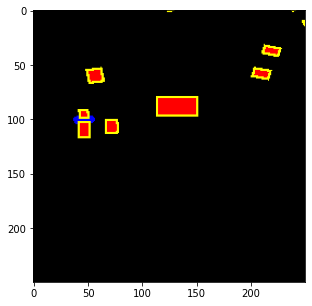

In [ ]:
f, ax = plt.subplots(figsize=(5, 5))
ax.imshow(fbc_mask, cmap='gray')

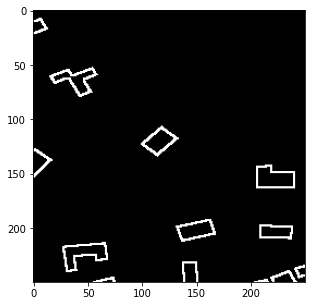

In [ ]:
b_mask = sol.vector.mask.boundary_mask(fp_mask, boundary_width=5)
f, ax = plt.subplots(figsize=(5, 5))
ax.imshow(b_mask, cmap='gray')

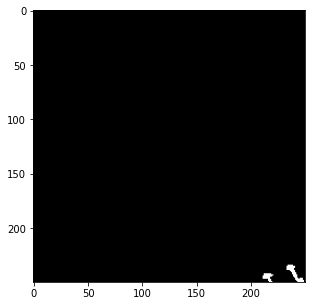

In [ ]:
c_mask = sol.vector.mask.contact_mask(df=sample_df,
                                      reference_im=getRefTile(sample_pth),
                                      contact_spacing=10, meters=True)
f, ax = plt.subplots(figsize=(5, 5))
ax.imshow(c_mask, cmap='gray')

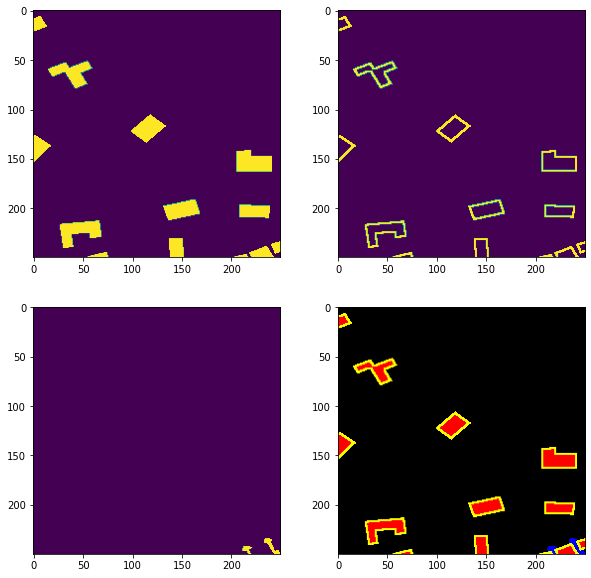

In [ ]:
fbc_mask = sol.vector.mask.df_to_px_mask(df=sample_df,
                                      reference_im=getRefTile(sample_pth),
                                      #out_file='data/rio_masks2.png', 
                                         channels=['footprint', 'boundary', 'contact'],
                                         boundary_width=5, contact_spacing=10, meters=True)
try: 
  fig, axes = plt.subplots(2,2,figsize=(10, 10))
  axes[0,0].imshow(fbc_mask[:,:,0])
  axes[0,1].imshow(fbc_mask[:,:,1])
  axes[1,0].imshow(fbc_mask[:,:,2])
  axes[1,1].imshow(fbc_mask)
except: 
  pass

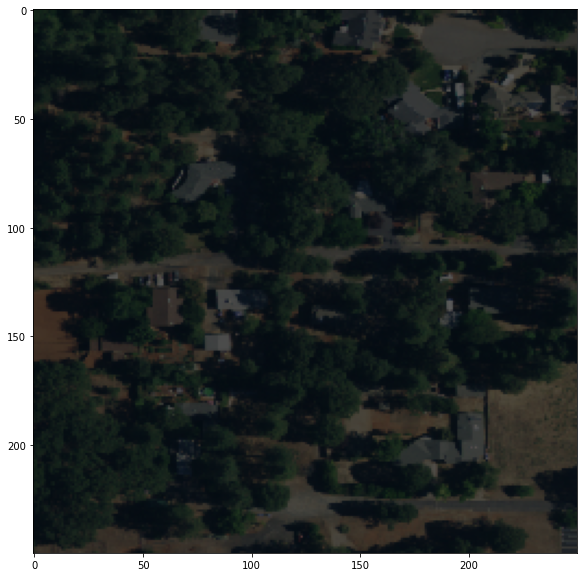

In [ ]:
  fig,ax = plt.subplots(1,1, figsize=(10,10))
  ax.imshow(skimage.io.imread(os.path.join(out_ras, nm + '.png')))
  ax.imshow(skimage.io.imread(os.path.join(out_fpnt, nm + '.png')), alpha=0.6)

### Build Masks based on Damage Classes & Save

In [ ]:
combined_csv = pd.read_csv( "data/all_loadedGeoTiles.csv")
damage_csvs = combined_csv[combined_csv['damage_count'] > 0]
damage_csvs.tail()

Fire  ...                                               Path
24323  Whittier  ...  data/fires/Whittier/label_chips/Whittier_2017_...
24324  Whittier  ...  data/fires/Whittier/label_chips/Whittier_2017_...
24325  Whittier  ...  data/fires/Whittier/label_chips/Whittier_2017_...
24326  Whittier  ...  data/fires/Whittier/label_chips/Whittier_2017_...
24333   Valley2  ...  data/fires/Valley2/label_chips/Valley2_2015_32...

[5 rows x 4 columns]

In [ ]:
def addDamageVals(sample_df):
  sample_df['Damage_val'] = sample_df['DAMAGE'].map({ 'No Damage' : 1, 
                              'Affected (1-9%)' : 2, 
                              'Minor (10-25%)': 2, 
                              'Major (26-50%)':2,
                              'Destroyed (>50%)' : 3})
  return sample_df

In [ ]:
! pip install pypng

In [ ]:
damage_csvs = damage_csvs.reset_index()
len(damage_csvs)

4155

In [ ]:
import png
from rasterio.plot import show
from PIL import Image

for i, row in damage_csvs.iterrows():
  jsn_pth = row['Path']
  nm = jsn_pth.split('/')
  nm = nm[-1]
  nm = nm.split('.')
  nm = '.'.join(nm[:3])

  jsn_df = gpd.read_file(jsn_pth)
  jsn_df = addDamageVals(jsn_df)
  
  out_fpnt = r'data/Model_Input_Dataset/Damage_Detection/Footprint_Chips'
  out_ras = 'data/Model_Input_Dataset/Damage_Detection/RGB_Chips'

  RIO_Ras = rasterio.open(getRefTile(jsn_pth))
  im = Image.open(getRefTile(jsn_pth))

  ras_png = im.convert("RGB")


  fp_mask = sol.vector.mask.footprint_mask(df=jsn_df,
                                        reference_im= RIO_Ras,
                                        burn_field ='Damage_val',
                                        geom_col = 'geometry',
                                        shape=(250,250),
                                        do_transform=True
                                        )

  ras_png.save(os.path.join(out_ras, nm + '.png'), "PNG")
  skimage.io.imsave(os.path.join(out_fpnt, nm + '.png'), fp_mask, check_contrast=False) 
  print(i, getRefTile(jsn_pth), jsn_pth) 
  # except: 
  #   print('error: ', row.Fire, jsn_pth) 
  #   continue


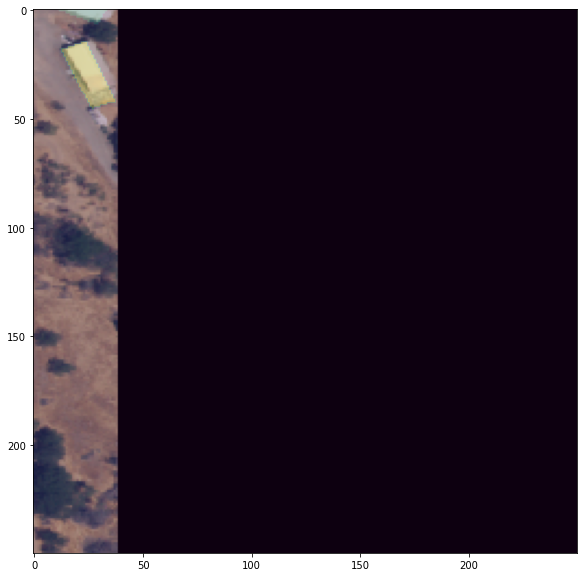

In [ ]:
  fig,ax = plt.subplots(1,1, figsize=(10,10))
  ax.imshow(skimage.io.imread(os.path.join(out_ras, nm + '.png')))
  ax.imshow(skimage.io.imread(os.path.join(out_fpnt, nm + '.png')), alpha=0.2)

#### one-off sub-cleaning, some files werent renamed properly

In [ ]:
tifList_toRename = glob.glob(f'data/fires/Valley/label_chips/Valley_2015_63_-122.761_38.844.geojson')
tifList_toRename

['data/fires/Valley/label_chips/Valley_2015_63_-122.761_38.844.geojson']

In [ ]:
len(lstFiles('data/fires/Thomas/rast_chips/', '.tif')),len(lstFiles('data/fires/Thomas/label_chips/', '.geojson'))

(24705, 24705)

In [ ]:
 import glob 

 def renameTif(tif_pth):
  tif_nm = tif_pth.split('/')
  tif_nm = tif_nm[-1]
  tif_nm = tif_nm.split('_')
  fire_nm = tif_nm[0]
  fire_yr = tif_nm[1]
  tif_coords = '_'.join(tif_nm[-2:])[:-4]

  # grab matching ID 
  ply_exists = glob.glob(f'data/fires/{fire_nm}/label_chips/{fire_nm}_{fire_yr}*{tif_coords}.geojson')
  ply_nm = ply_exists[0].split('/')
  ply_nm = ply_nm[-1]
  ply_nm = ply_nm.split('_')
  ply_id = ply_nm[2]

  new_tif_nm = f'data/fires/{fire_nm}/rast_chips/{fire_nm}_{fire_yr}_{ply_id}_{tif_coords}.tif'

  os.rename(tif_pth, new_tif_nm)

  print(tif_pth, new_tif_nm)

In [ ]:
for tifs in tifList_toRename: 
  renameTif(tifs)

In [ ]:
out_fpnt = r'data/Model_Input_Dataset/Damage_Detection/Footprint_Chips'
out_ras = r'data/Model_Input_Dataset/Damage_Detection/RGB_Chips'

tile_tifs = lstFiles(out_ras, '.png')
tile_poly = lstFiles(out_fpnt, '.png')

In [ ]:
len(tile_tifs), len(tile_poly)

(4155, 4155)

### Convert Label Chips to MultiChannel PNG

In [ ]:
import PIL.Image
import numpy as np
import cv2

def convertToMultiChannel(poly): 
  '''
  Input: pathname to png mask file 

  Issue: Solaris masks save burn field into one channel. 
  This converts the individual class values (1, 2, 3) corresponding to damage class 
  into invidual channels as 3-D arrays with shape (250, 250). 

  Returns new multichannel array 
  '''
  image = PIL.Image.open(poly)
  arr = np.array(image)

  inds_1 = np.where(arr == 1, 255, 0)
  inds_2 = np.where(arr == 2, 255, 0)
  inds_3 = np.where(arr == 3, 255, 0)

  multi_channel_img = np.zeros((inds_1.shape[0], inds_1.shape[1], 3))

  multi_channel_img [:,:,0] = inds_1
  multi_channel_img [:,:,1] = inds_2
  multi_channel_img [:,:,2] = inds_3
  return (multi_channel_img)

In [ ]:
outpath = r'data/Model_Input_Dataset/Damage_Detection/Footprint_Chips_Multichannel'

for poly in tile_poly: 
  ply_nm = poly.split('/')
  ply_nm = ply_nm[-1]

  new_img = convertToMultiChannel(poly)
  cv2.imwrite(os.path.join(outpath, ply_nm), new_img)

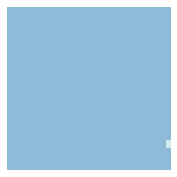

In [ ]:
import pathlib
img = open_mask(os.path.join(outpath, ply_nm))
img.show()

### Create Holdout Set

In [ ]:
def getPNGPAIR(mask_png_path):
  rep = {"Footprint_Chips": "RGB_Chips"} # define desired replacements here

  # use these three lines to do the replacement
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], mask_png_path)
  return text

def getNewPath(mask_png_path, foldername):
  rep = {f"{foldername}": f"Holdout/{foldername}"} # define desired replacements here

  # use these three lines to do the replacement
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], mask_png_path)
  return text

In [ ]:
import shutil 
import re

def moveToHoldOUT(mask_png_path):

  rast_png = getPNGPAIR(mask_png_path)

  new_rast_png = getNewPath(rast_png, 'RGB_Chips')
  new_ft_png = getNewPath(mask_png_path, 'Footprint_Chips')


  shutil.move(rast_png, new_rast_png)
  shutil.move(mask_png_path, new_ft_png)
              
  print('Moved to holdout folder:')


In [ ]:
combined_csv = pd.read_csv( "data/all_loadedGeoTiles.csv")

In [ ]:
geo_csvs = combined_csv[(combined_csv['damage_count'] > 3) & (combined_csv['damage_count'] < 20) | 
                        (combined_csv['geo_count'] > 10) & (combined_csv['geo_count'] < 20)].reset_index() #(combined_csv['geo_count'] > 4) & 

len(geo_csvs)

3810

In [ ]:
geo_csvs['Pre_Fire_Path'] = geo_csvs['Path']
geo_csvs['Post_Fire_Path'] = geo_csvs['Path'].str.replace('prefire_data','postfire_data')
geo_csvs = geo_csvs.drop(columns=['Path'])
geo_csvs

In [ ]:
def createHoldOutData(post_prefire_path, folder):
  for path in geo_csvs[post_prefire_path].tolist():
    nm = path.split('/')
    nm = nm[-1]
    nm = nm.split('.')
    nm = '.'.join(nm[:3])
    fl_nm = f'data/Model_Input_Dataset/{folder}/Footprint_Chips/{nm}.png'
    if os.path.exists(fl_nm) == True: 
      try: 
        moveToHoldOUT(fl_nm)
        print(nm)
      except: 
        print('error', nm)
        continue

In [ ]:
!ls data/Model_Input_Dataset/Postfire_Damage_Detection/RGB_Chips

In [ ]:
createHoldOutData('Post_Fire_Path', 'Postfire_Damage_Detection')

In [ ]:
ft_chips = lstFiles('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/Footprint_Chips', '.png')
RGB_chips = lstFiles('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips', '.png')

In [ ]:
from shutil import copyfile
import re

for i, fl_path in enumerate(RGB_chips):
  rep = {"Postfire_Damage_Detection/Holdout/": "Postfire_Damage_Detection/"} # define desired replacements here

  # use these three lines to do the replacement
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], fl_path)

  #print(fl_path, text)
  copyfile(fl_path, text)
  print((i/len(RGB_chips) * 100), 'percent copied')
  
ipd.display(ipd.Audio(soundfile1, autoplay=True))

## DL w/ fastai & pytorch

In [ ]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9127    0  9127    0     0  54327      0 --:--:-- --:--:-- --:--:-- 54327
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [ ]:
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
from fastai.utils.collect_env import *
show_install(True)

In [ ]:
path_lbl = r'data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/Footprint_Chips'
path_img = r'data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips'

In [ ]:
!ls data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips

In [ ]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3] 

728 728


([PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips/Butte_2015_2497_-120.632_38.286.png'),
  PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips/Butte_2015_2984_-120.616_38.248.png'),
  PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips/Butte_2015_3795_-120.591_38.291.png')],
 [PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/Footprint_Chips/Tubbs_2017_1134_-122.728_38.534.png'),
  PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/Footprint_Chips/Tubbs_2017_1133_-122.728_38.532.png'),
  PosixPath('data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/Footprint_Chips/Tubbs_2017_243_-122.753_38.485.png')])

In [ ]:
get_y_fn = lambda x: Path(str(x).replace('RGB_Chips/', 'Footprint_Chips/'))

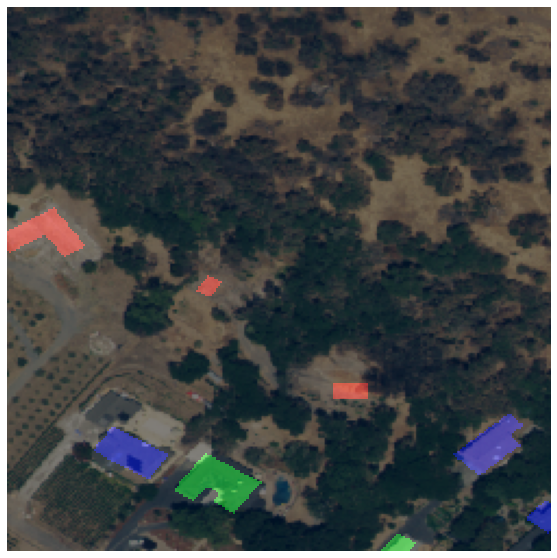

In [ ]:
import pathlib
# test that masks are opening correctly with open_mask() settings
img_f = fnames[20]
img = open_image(img_f)
p = Path(str(img_f).replace('RGB_Chips', 'Footprint_Chips'))
mask = open_mask(p,convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.4)

(array([181207.,      0.,      0.,      0.,      0.,   6293.]),
 array([  0. ,  42.5,  85. , 127.5, 170. , 212.5, 255. ]),
 <a list of 6 Patch objects>)

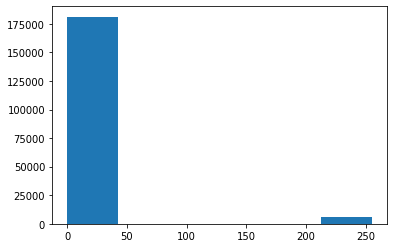

In [ ]:
plt.hist(mask.data.reshape(-1), bins=6)

In [ ]:
mask.data

### Setup Data

In [ ]:
strNames = [x.stem for x in fnames]

random.shuffle(strNames)

ind_30 = int(len(strNames) * 0.90)
ind_10 = int(len(strNames) * 0.10)


train_data = strNames[:ind_30]
test_data = strNames[ind_30:ind_30+ind_10]
len(train_data), len(test_data), 

(655, 72)

In [ ]:
# using naive method 
# to find indices for 3 
test_vals = [] 
for i, fn in enumerate(fnames): 
  if fn.stem in (test_data): 
      test_vals.append(i) 

len(test_vals)

72

In [ ]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB') #, div=True, convert_mode='RGB'
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [ ]:
# the classes corresponding to each channel
codes = np.array(['Destoyed', 'Damaged', 'No-Damage'])

In [ ]:
size = 250
bs =44

In [ ]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=False, max_warp=0, max_rotate=0, max_zoom=0, max_lighting=0)

src = (SegItemListCustom.from_folder(path_img)
        .split_by_idx(test_vals)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
def show_3ch(imgitem, figsize=(10,5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    ax1.imshow(np.asarray(imgitem.data[0,None])[0])
    ax2.imshow(np.asarray(imgitem.data[1,None])[0])
    ax3.imshow(np.asarray(imgitem.data[2,None])[0])
    
    
    ax1.set_title('Destroyed')
    ax2.set_title('Damaged')
    ax3.set_title('No-Damage')
    
    plt.show()

Atlas_2017_3659_-122.253_38.345.png


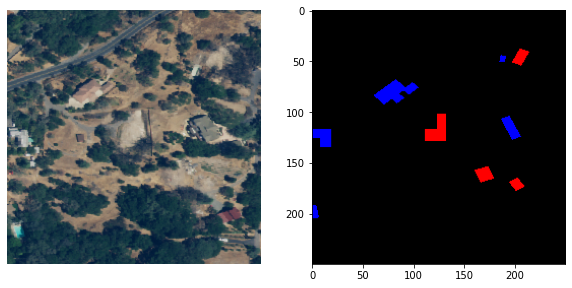

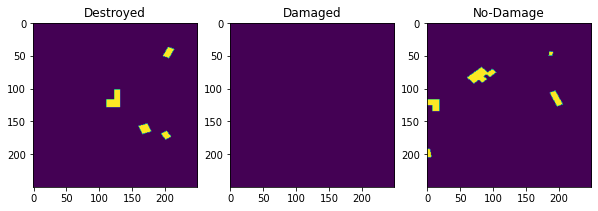

Atlas_2017_3567_-122.255_38.358.png


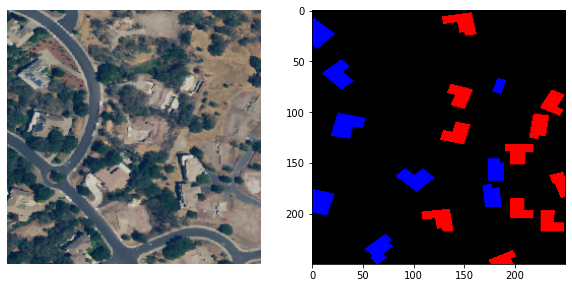

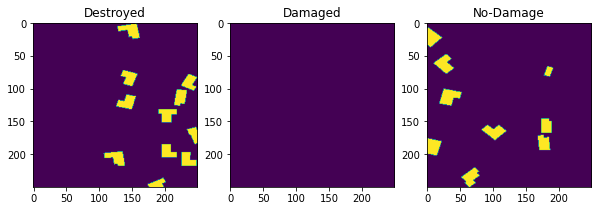

Atlas_2017_1811_-122.296_38.376.png


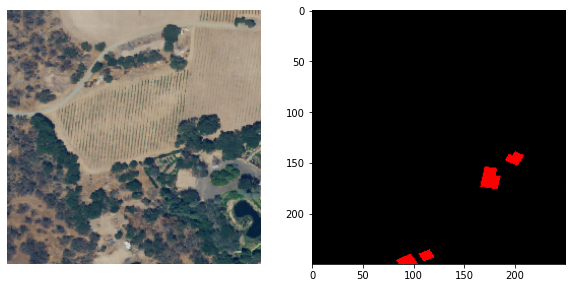

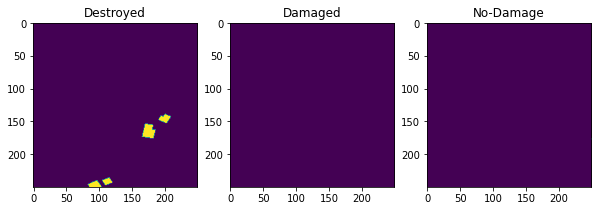

Atlas_2017_2008_-122.291_38.379.png


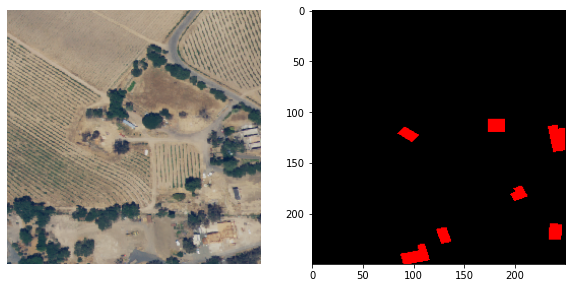

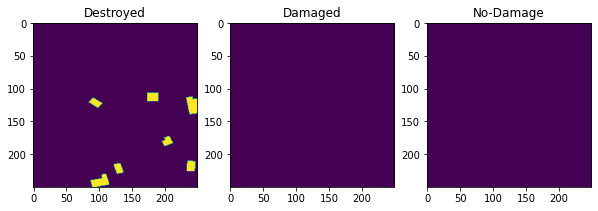

In [ ]:
for idx in range(1,5):
    print(data.valid_ds.items[idx].name)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    data.valid_ds.x[idx].show(ax=ax1)
    ax2.imshow(image2np(data.valid_ds.y[idx].data*255))
    plt.show()
    show_3ch(data.valid_ds.y[idx])

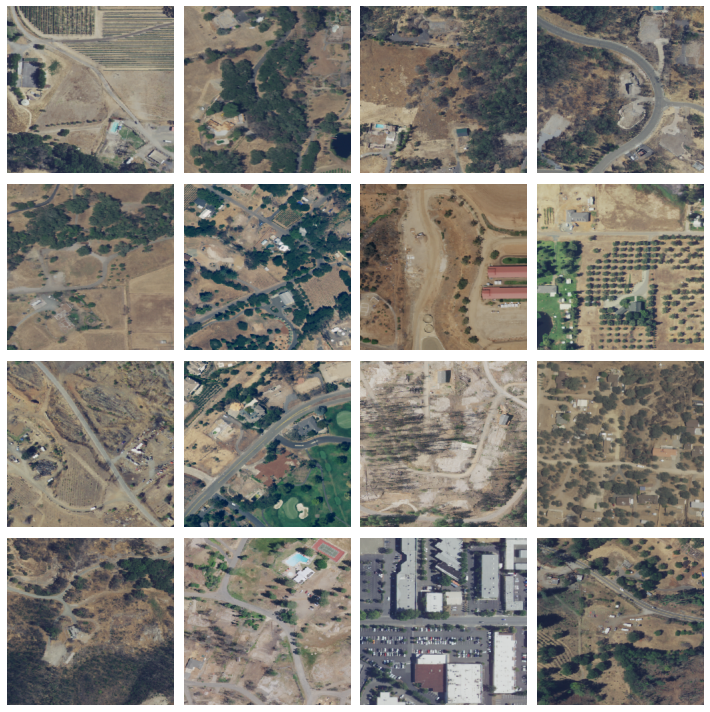

In [ ]:
data.show_batch(4,figsize=(10,10), alpha=0)

In [ ]:
data

ImageDataBunch;

Train: LabelList (656 items)
x: SegItemListCustom
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegLabelListCustom
ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250)
Path: data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips;

Valid: LabelList (72 items)
x: SegItemListCustom
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegLabelListCustom
ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250),ImageSegment (3, 250, 250)
Path: data/Model_Input_Dataset/Postfire_Damage_Detection/Holdout/RGB_Chips;

Test: None

### Define custom losses and metrics for multi-level targets

In [ ]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [ ]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

### Setup Model

In [ ]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)

acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [ ]:
# combo Focal + Dice loss with equal channel wts

learn = unet_learner(data, models.resnet34, model_dir='models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

In [ ]:
learn.metrics

[<function __main__.acc_thresh_multich>,
 <function __main__.dice_multich>,
 functools.partial(<function acc_thresh_multich at 0x7f804b305598>, one_ch=0),
 functools.partial(<function dice_multich at 0x7f804b3056a8>, one_ch=0)]

In [ ]:
learn.loss_func

MultiChComboLoss()

In [ ]:
#learn.summary()

### Train Model

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-05
Min loss divided by 10: 2.75E-03


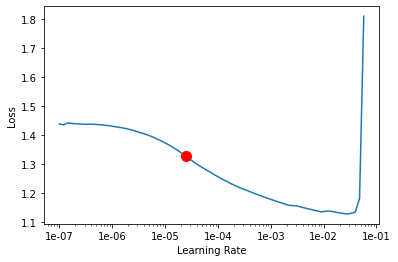

In [ ]:
learn.recorder.plot(0,2,suggestion=True)

In [ ]:
lr = 1e-4
learn.fit_one_cycle(20, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-alpha')
                    ]
                   )

Better model found at epoch 0 with dice_multich value: 0.002969050547108054.
Better model found at epoch 3 with dice_multich value: 0.015163966454565525.
Better model found at epoch 4 with dice_multich value: 0.04871126636862755.
Better model found at epoch 6 with dice_multich value: 0.14812858402729034.
Better model found at epoch 7 with dice_multich value: 0.1684909462928772.
Better model found at epoch 8 with dice_multich value: 0.3209444284439087.
Better model found at epoch 9 with dice_multich value: 0.35046735405921936.
Better model found at epoch 10 with dice_multich value: 0.35244259238243103.
Better model found at epoch 11 with dice_multich value: 0.36546698212623596.


In [ ]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=3,with_loss=True)
losses.shape

torch.Size([72, 1, 250, 250])

In [ ]:
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)
losses_reshaped.shape

torch.Size([72])

In [ ]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sorted_idx

tensor([12,  6,  8, 13,  3,  1,  0,  7, 14, 11,  2,  4,  5,  9, 10])

In [ ]:
!ls data/Model_Input_Dataset/Prefire_Footprint_Detection/models/

tmp.pth  znz001trn-focaldice.pkl  znz001trn-focaldice-stage1-best.pth


In [ ]:
# load and unfreeze previously saved model 
learn.load('znz001trn-focaldice-stage1-alpha')
learn.model.train()
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-05


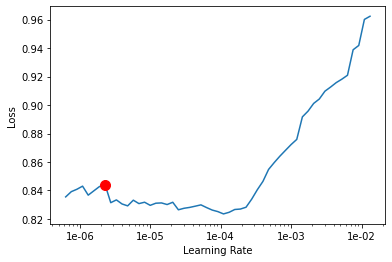

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
# unfreeze and save new models in 'name'
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name='znz001trn-focaldice-unfrozen-best_19')
                    ]
                   )

Better model found at epoch 0 with dice_multich value: 0.1441912055015564.
Better model found at epoch 1 with dice_multich value: 0.35412782430648804.
Better model found at epoch 3 with dice_multich value: 0.3579019010066986.


In [ ]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

In [ ]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:-10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

Output hidden; open in https://colab.research.google.com to view.

### Save final model

In [ ]:
# pickling with custom classes like MultiChComboLoss is a bit tricky 
learn.export('models/znz001trn-focaldice-D.pkl')

## Inference with Post-Fire Imagery

In [ ]:
!ls data/Model_Input_Dataset/Prefire_Footprint_Detection/RGB_Chips/models

tmp.pth
znz001trn-focaldice-C.pkl
znz001trn-focaldice-D.pkl
znz001trn-focaldice-stage1-alpha.pth
znz001trn-focaldice-stage1-best.pth
znz001trn-focaldice-unfrozen-best_10.pth
znz001trn-focaldice-unfrozen-best_11.pth
znz001trn-focaldice-unfrozen-best_12.pth
znz001trn-focaldice-unfrozen-best_13.pth
znz001trn-focaldice-unfrozen-best_14.pth
znz001trn-focaldice-unfrozen-best_15.pth
znz001trn-focaldice-unfrozen-best_16.pth
znz001trn-focaldice-unfrozen-best_17.pth
znz001trn-focaldice-unfrozen-best_18.pth
znz001trn-focaldice-unfrozen-best_19.pth
znz001trn-focaldice-unfrozen-best_2.pth
znz001trn-focaldice-unfrozen-best_3.pth
znz001trn-focaldice-unfrozen-best_4.pth
znz001trn-focaldice-unfrozen-best_5.pth
znz001trn-focaldice-unfrozen-best_6.pth
znz001trn-focaldice-unfrozen-best_7.pth
znz001trn-focaldice-unfrozen-best_8.pth
znz001trn-focaldice-unfrozen-best_9.pth
znz001trn-focaldice-unfrozen-best.pth


In [ ]:
inference_learner = load_learner(path='data/Model_Input_Dataset/Prefire_Footprint_Detection/RGB_Chips/models', file='znz001trn-focaldice-D.pkl')

In [ ]:
postFire_png = lstFiles('data/Model_Input_Dataset/Postfire_Damage_Detection/RGB_Chips','png')

In [ ]:
def getNewPath(mask_png_path):
  rep = {f"Postfire_Damage_Detection": f"Prefire_Footprint_Detection"} # define desired replacements here

  # use these three lines to do the replacement
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], mask_png_path)
  return text

In [ ]:
import skimage.io 
import time

def get_pred(learner, tile):
#     pdb.set_trace()
    t_img = Image(pil2tensor(tile[:,:,:3],np.float32).div_(255))
    outputs = learner.predict(t_img)
    im = image2np(outputs[2].sigmoid())
    im = (im*255).astype('uint8')
    return im

In [ ]:
len(postFire_png)

4155

In [ ]:
for url in postFire_png[:50]:
  try: 
    t1 = time.time()
    pre_tile = skimage.io.imread(url)
    pre_result = get_pred(inference_learner, pre_tile)
    t2 = time.time()


    post_tile = skimage.io.imread(getNewPath(url))
    post_result = get_pred(inference_learner, post_tile)



    
    print(url)
    print(f'GPU inference took {t2-t1:.2f} secs')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,20))
    ax1.imshow(pre_tile)
    ax2.imshow(pre_result)
    ax3.imshow(post_tile)
    ax4.imshow(post_result)
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
  except: 
    continue

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pre_result

np.nonzero(pre_result)

x[np.nonzero(x)]

(array([  0,   0,  64,  65, ..., 247, 247, 249, 249]),
 array([245, 247,  24,  24, ..., 166, 167, 161, 165]),
 array([0, 0, 0, 0, ..., 0, 0, 0, 0]))

## Polygonize Raster

Using solaris and geopandas, we'll convert our model's prediction as a 3-channel pixel raster output into a GeoJSON file by:

1.   thresholding and combining the 3-channels of pixel values in our raw prediction output into a 1 channel binary pixel mask
2.   polygonizing this binary pixel mask into shape vectors representing the predicted footprint of every building
3.   georegistering the x, y display coordinates of these vectorized building shapes into longitude, latitude coordinates



In [ ]:
import solaris as sol 
from affine import Affine
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
import math
import geopandas as gpd
import skimage

In [ ]:
!ls data/prefire_data/Nuns/label_chips/Nuns_2017_3571_-122.56_38.421.geojson

data/prefire_data/Nuns/label_chips/Nuns_2017_3571_-122.56_38.421.geojson


In [ ]:
file_nm = 'Atlas_2017_2358_-122.282_38.284'
fire_nm = 'Atlas'

In [ ]:
tile = skimage.io.imread(f'data/Model_Input_Dataset/Prefire_Footprint_Detection/RGB_Chips/{file_nm}.png')
result = get_pred(inference_learner, tile)

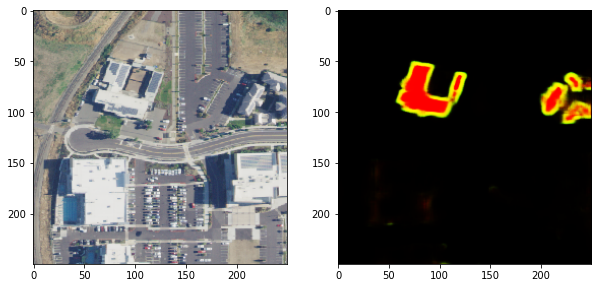

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(tile)
ax2.imshow(result)
plt.show()

In [ ]:
!ls data/prefire_data/Atlas/rast_chips/

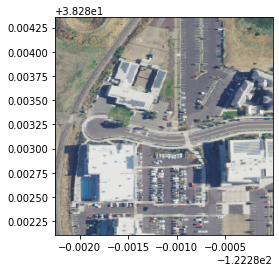

In [ ]:
import rasterio
from rasterio.plot import show
ras_file = rasterio.open(f'data/prefire_data/{fire_nm}/rast_chips/{file_nm}.tif')
show(ras_file)

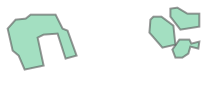

In [ ]:
from shapely.ops import cascaded_union
# threshold and polygonize with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_mask_to_vector.html

# mask2poly = sol.vector.mask.mask_to_poly_geojson(result, 
#                                                  channel_scaling=[2, 0, -1],
#                                                  simplify=True,
#                                                  tolerance=2,
#                                                  bg_threshold=250)
geoms = sol.vector.mask.mask_to_poly_geojson(result, 
                                             reference_im = ras_file,
                                             channel_scaling=[2, 0, -1], 
                                             bg_threshold=254,
                                             tolerance=2,
                                             simplify=True,
                                             do_transform=False)
cascaded_union(geoms['geometry'])

### Georegister Polygon

In [ ]:
tfm = from_bounds(*ras_file.bounds, 250, 250)


result_polys = sol.vector.polygon.georegister_px_df(geoms, 
                                                  affine_obj = tfm,
                                                  crs = 4326)

In [ ]:
!ls data/prefire_data/Atlas/label_chips/

In [ ]:
observed = gpd.read_file(f'data/prefire_data/{fire_nm}/label_chips/{file_nm}.geojson')

/usr/local/lib/python3.6/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.6/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


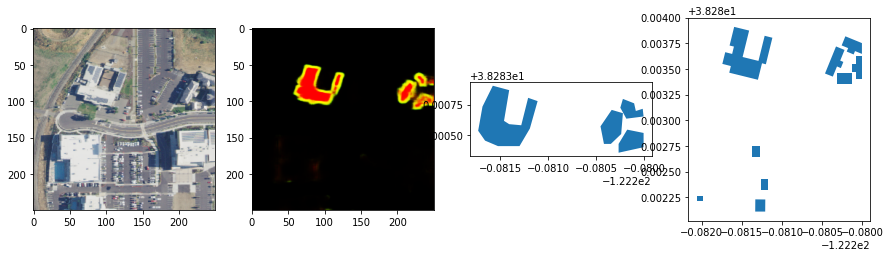

In [ ]:
# show tile image to raw prediction to georegistered polygons
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))

ax1.imshow(tile)
ax2.imshow(result)
result_polys.plot(ax=ax3)
observed.plot(ax=ax4)

In [ ]:
result_polys.to_file(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/poly/{file_nm}.geojson', driver='GeoJSON')

## Evaluate

In [ ]:
# solaris tutorial on evaluation: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_evaluation_tutorial.html 
evaluator = sol.eval.base.Evaluator(f'data/prefire_data/{fire_nm}/label_chips/{file_nm}.geojson')
evaluator.load_proposal(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/poly/{file_nm}.geojson', proposalCSV=False, conf_field_list=[])
eval_result = evaluator.eval_iou(calculate_class_scores=False)

In [ ]:
eval_result[0].update({'Fire': fire_nm,
                     'ID': file_nm})

pd.DataFrame(eval_result[0], index=['a']) 

class_id      iou_field  ...   Fire                               ID
a      all  iou_score_all  ...  Atlas  Atlas_2017_2358_-122.282_38.284

[1 rows x 10 columns]

/usr/local/lib/python3.6/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.6/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.6/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


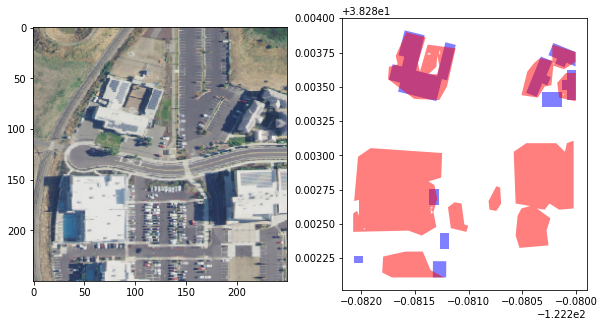

In [ ]:
# visualize predicted vs ground truth
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.imshow(tile)
observed.plot(ax=ax2, color='blue', alpha=0.5) #gt
result_polys.plot(ax=ax2, color='red', alpha=0.5) #pred

## Create Post-Processing Functions

### Prediction & save output


In [ ]:
import solaris as sol 
from affine import Affine
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
import math
import geopandas as gpd
import skimage
import skimage.io 

from shapely.ops import cascaded_union

In [ ]:
def getFileNames(fire_nm):
  jsonFiles = lstFiles(f'data/prefire_data/{fire_nm}/label_chips', '.geojson')
  fileList = []
  for json in jsonFiles: 
    if fire_nm in json:
      # Get the filename only from the initial file path.
      filename = os.path.basename(json)
      
      # Use splitext() to get filename and extension separately.
      (file, ext) = os.path.splitext(filename)
      fileList.append(file)
  return fileList, fire_nm

In [ ]:
from PIL import Image as IM

def TIFToPNG(fire_nm, tif_name, file_nm):
  im_tif = IM.open(tif_name)
  ras_png = im_tif.convert("RGB")
  rasPNG_outPath = createFolder('data/Model_Output_Dataset/Prefire_Footprint_Detection/RGB_chips', fire_nm)
  ras_png.save(os.path.join(rasPNG_outPath, file_nm + '.png'), "PNG")

In [ ]:

def predEvaluate(fire_nm):
  print(fire_nm)
  file_lst, fire_nm = getFileNames(fire_nm)
  printcounter = 0
  k = 20
  for i, file_nm in enumerate(file_lst):
    tif_name = f'data/prefire_data/{fire_nm}/rast_chips/{file_nm}.tif'
    ras_file = rasterio.open(tif_name)
    # convert tif to png 
    TIFToPNG(fire_nm, tif_name, file_nm)

    # read in png image 
    rasPNG_outPath = f'data/Model_Output_Dataset/Prefire_Footprint_Detection/RGB_chips/{fire_nm}'
    # os.path.join(rasPNG_outPath, file_nm + '.png')
    
    tile_name = os.path.join(rasPNG_outPath, file_nm + '.png')
    tile = skimage.io.imread(tile_name)

    # perform prediction
    result = get_pred(inference_learner, tile)

    try: 
      # convert rast to vector polygon, simplify geo
      geoms = sol.vector.mask.mask_to_poly_geojson(result, 
                                                  reference_im = ras_file,
                                                  channel_scaling=[2, 0, -1], 
                                                  bg_threshold=254,
                                                  tolerance=2,
                                                  simplify=True,
                                                  do_transform=False)
      
      # get ras bounds 
      tfm = from_bounds(*ras_file.bounds, 250, 250)

      # georegister 
      result_polys = sol.vector.polygon.georegister_px_df(geoms, 
                                                        affine_obj = tfm,
                                                        crs = 4326)

      # save poly prediction
      poly_outPath = createFolder('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_poly', fire_nm)
      result_polys.to_file(os.path.join(poly_outPath, f'{file_nm}.geojson'), driver='GeoJSON')
      
      printcounter += 1

      if printcounter % k  == 0:
        print(round((i/len(file_lst)*100),1), '% completed')
    
    except: 
      printcounter += 1
      continue 

### Compile & Merge all footprints

In [ ]:
def mergeChipPoly(fire_nm):
  predicted_poly = lstFiles(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_poly/{fire_nm}', '.geojson')
  poly1 = gpd.read_file(predicted_poly[0])
  poly2 = gpd.read_file(predicted_poly[1])
  merged = poly1.append(poly2)
  for i, poly in enumerate(predicted_poly[2:]):
    poly3 = gpd.read_file(predicted_poly[i])
    merged = merged.append(poly3)
  merged.to_file(f"data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/{fire_nm}_PredictedBuildings.geojson", driver='GeoJSON')
  return merged

### Evaluate for entire fire region

In [ ]:
def evaluatePred(fire_nm, fire_yr):
  fire_yr = str(fire_yr)[:4]
  observed_filepath = f'data/prefire_data/{fire_nm}/poly/{fire_nm}_{fire_yr}_buildingfptn.geojson'
  
  observed = gpd.read_file(observed_filepath)
  predicted = gpd.read_file(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/{fire_nm}_PredictedBuildings.geojson')

  evaluator = sol.eval.base.Evaluator(observed_filepath)
  evaluator.load_proposal(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/{fire_nm}_PredictedBuildings.geojson', proposalCSV=False, conf_field_list=[])
  eval_result = evaluator.eval_iou(miniou=0.2, calculate_class_scores=False)
  eval_result[0].update({'Fire': fire_nm})
  df = pd.DataFrame(eval_result[0], index=[0]) 
  csv_outPath = 'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/eval_csv/'
  df.to_csv(os.path.join(csv_outPath,f'{fire_nm}.csv'))

## Perform All Steps: Predict, Compile, Evaluate 

In [ ]:
import pandas as pd
# get list of fire and year 
#bounds_gdf['Fire_Year'] = pd.to_datetime(bounds_gdf['Year'], format='%m/%d/%Y').dt.year

def removeDuplicates(lst): 
    return [t for t in (set(tuple(i) for i in lst))] 
          
# Driver code 
outpath = os.path.join('data', 'boundingbox_byfire')
bounds_gdf = gpd.read_file(os.path.join(outpath, 'boundingbox_byfire.geojson'), driver='GeoJSON')

fire_names = [x for x in bounds_gdf['Fire']]
fire_list = list(zip(fire_names, bounds_gdf['Year']))
fire_list = removeDuplicates(fire_list)

fire_list = sorted(fire_list, key=lambda tup: tup[0])
fire_list

In [ ]:
!ls data/Model_Input_Dataset/Prefire_Footprint_Detection/Footprint_Chips
!ls data/Model_Input_Dataset/Prefire_Footprint_Detection/RGB_Chips

In [ ]:
!ls data/prefire_data/Thomas/label_chips
!ls data/prefire_data/Thomas/rast_chips

In [ ]:
!ls data/prefire_data/Alamo/poly/

Alamo_2017_buildingfptn.geojson


In [ ]:
for fire_nm, fire_yr in fire_list:
  try:  
    # predEvaluate(fire_nm)
    # mergeChipPoly(fire_nm)
    evaluatePred(fire_nm, fire_yr)
  except: 
    print('error', fire_nm, fire_yr)
    continue

In [ ]:
csv_files = lstFiles('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/eval_csv', '.csv')

In [ ]:
csv_files

combined_csv = pd.concat([pd.read_csv(f) for f in csv_files])
combined_csv.to_csv( "data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/combined_csvEval.csv", index=False)

In [ ]:
combined_csv = pd.read_csv("data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/combined_csvEval.csv")

In [ ]:
#result = pd.merge(left, right, on='key')
df = pd.DataFrame(data=fire_list)
df.columns = ['Fire', 'Year']
df['Year'] = df['Year'].astype(str).str[:4]
result = pd.merge(combined_csv, df, on='Fire')


result.sort_values(by=['Precision'], ascending=False)[:10]

Unnamed: 0 class_id      iou_field  ...   F1Score      Fire  Year
0            0      all  iou_score_all  ...  0.363636     Alamo  2017
1            0      all  iou_score_all  ...  0.470588      Bear  2017
2            0      all  iou_score_all  ...  0.719476     Atlas  2017
3            0      all  iou_score_all  ...  0.675906     Boles  2014
4            0      all  iou_score_all  ...  0.245609     Butte  2015
..         ...      ...            ...  ...       ...       ...   ...
66           0      all  iou_score_all  ...  0.772355    Valley  2015
67           0      all  iou_score_all  ...  0.583333     Vista  2018
68           0      all  iou_score_all  ...  0.692103      Wall  2017
69           0      all  iou_score_all  ...  0.714286      West  2018
70           0      all  iou_score_all  ...  0.327869  Whittier  2017

[71 rows x 11 columns]

In [ ]:
result.to_csv( "data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/combined_csvEval.csv", index=False)

In [ ]:
flatui = ["#9b59b6", "#3498db", "#f5c64e", "#e74c3c", "#2ecc71",'#898a75', '#95a5a6']
pal = sns.color_palette(flatui)

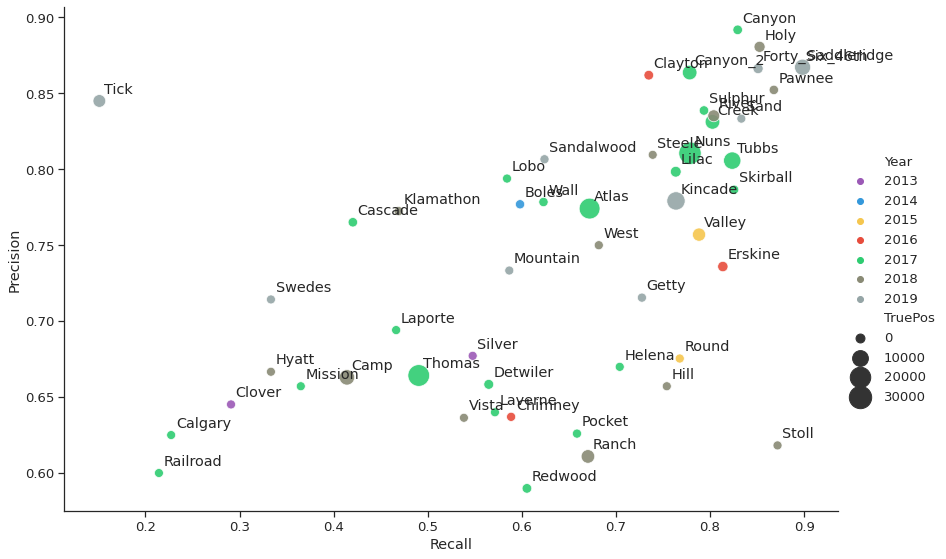

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set(style='ticks', font_scale=1.2)


result = result[result['Precision'] > 0.55] 

ax = sns.relplot(x="Recall", y="Precision", hue='Year', size="TruePos",
            sizes=(80, 500), alpha=.9, palette= pal,
            height=8, aspect=1.5, data=result)


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y']+0.005, str(point['val']))

label_point(result.Recall, result.Precision, result.Fire, plt.gca())  

plt.savefig('figures/buildingPrediction_Eval.jpeg', dpi=400)

## Interactive Mapping: Observed vs Predicted

In [ ]:
I’m fire_nm = 'Tubbs'
fire_yr = '2017'

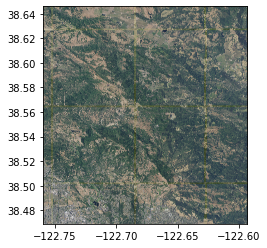

In [ ]:
from rasterio.plot import show
ras_file = rasterio.open(f'data/prefire_data/{fire_nm}/RGBN/{fire_nm}_{fire_yr}_preFire.tif')
show(ras_file)

In [ ]:
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000

im_tif = Image.open(f'data/prefire_data/{fire_nm}/RGBN/{fire_nm}_{fire_yr}_preFire.tif')
ras_png = im_tif.convert("RGB")
ras_png.save(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/png_basemap/{fire_nm}_{fire_yr}_preFire.png', "PNG")

In [ ]:
ras_file.bounds

BoundingBox(left=-122.75980515737083, bottom=38.46899558633949, right=-122.59320360477803, top=38.646062511992284)

In [ ]:
!ls data/prefire_data/Atlas/RGBN

Atlas_2017_preFire.tif


In [ ]:
import folium
from folium.plugins import MarkerCluster
from PIL import Image
#PIL.Image.MAX_IMAGE_PIXELS = 933120000

def interMap(fire_nm, fire_yr):
  # basemap = f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/png_basemap/{fire_nm}_{fire_yr}_preFire.png'
  predicted = gpd.read_file(f'data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire/poly/{fire_nm}_PredictedBuildings.geojson')
  observed = gpd.read_file(f'data/prefire_data/{fire_nm}/poly/{fire_nm}_{fire_yr}_buildingfptn.geojson')

  maploc = folium.Map(location=[38.542145, -122.657199],zoom_start=13,tiles="Stamen Toner")
  #add fire perimeters 
  folium.GeoJson(
      observed,
      style_function=lambda feature: {
          'fillColor': '#12b19e',
          'color' : '#000069',
          'weight' : 1,
          'fillOpacity' : 0.5,
          }
      ).add_to(maploc)

  # add in building polygons 
  # color by damage type 
  folium.GeoJson(
      predicted,
      style_function=lambda feature: {
          'fillColor': '#b14e12',
          'color' : '#b11225',
          'weight' : 1,
          'fillOpacity' : 0.5,
          }
      ).add_to(maploc)

  # img = folium.raster_layers.ImageOverlay(
  #       image= basemap,
  #       bounds = [[38.46899558633949, -122.75980515737083],[38.646062511992284, -122.59320360477803]],
  #       overlay = False,
  #   ).add_to(maploc)
  outpath = createFolder('data/Model_Output_Dataset/Prefire_Footprint_Detection/predicted_byFire', 'Maps')  
  maploc.save(f'{outpath}{fire_nm}_buildingfootprint.html')
  return maploc

In [ ]:
interMap('Tubbs', '2017')

Output hidden; open in https://colab.research.google.com to view.